# 2. Modélisation (langage python)

# 2.1 Prédiction des calories brulées (régression)

## 2.1.1 Ajustement des données 

imports:

In [ ]:
#install.packages("plotly")
#install.packages("FactoMineR")
#install.packages("factoextra")
#install.packages("glmnet")
#install.packages("ggfortify")
#install.packages("pROC")
#install.packages("ROCR")
#install.packages("corrplot")
#install.packages("fastDummies")
#install.packages("rpart.plot")
#install.packages("partykit")
#install.packages("randomForest")
#install.packages("ggRandomForests")
#install.packages("gbm")

Installation du package dans 'C:/Users/Thomas/AppData/Local/R/win-library/4.4'
(car 'lib' n'est pas spécifié)



le package 'gbm' a été décompressé et les sommes MD5 ont été vérifiées avec succés

Les packages binaires téléchargés sont dans
	C:\Users\Thomas\AppData\Local\Temp\RtmpWka3hV\downloaded_packages


In [ ]:
library(gbm)
library(nnet)
library(fastDummies)
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)
library(MASS) 
library(class)
library(rpart.plot)
library(rpart)
library(partykit)
library(caret)
library(randomForest)
library(ggRandomForests)
library(e1071)

In [45]:
# Lecture des données
# path="http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
path <- ""
data <- read.table(paste(path, "gym_members_exercise_tracking.csv", sep = ""),
                    sep = ",", header = TRUE)

In [46]:
# Fonction corrigée avec tidy eval
make_plot <- function(data, var, title, binwidth = NULL) {
  ggplot(data, aes(x = {{ var }})) +
    geom_histogram(aes(y = after_stat(density)),
                   fill = "lightblue",
                   color = "black",
                   binwidth = binwidth) +
    geom_density(alpha = 0.4, color = "blue") +
    ggtitle(title) +
    theme_minimal(base_size = 12)
}

In [47]:
data[, "Gender"] <- as.factor(data[, "Gender"])
data[, "Workout_Type"] <- as.factor(data[, "Workout_Type"])
data[, "Experience_Level"] <- as.factor(data[, "Experience_Level"])
data[, "Workout_Frequency..days.week."] <- as.factor(data[, "Workout_Frequency..days.week."])

In [48]:
data_norm <- data
data_norm[, "sBMI"] <- sqrt(data_norm[, "BMI"])
data_norm[, "sWeight..kg."] <- sqrt(data_norm[, "Weight..kg."])
data_norm[, "sCalories_Burned"] <- sqrt(data_norm[, "Calories_Burned"])
lambda = 2
data_norm[, "BCFat_Percentage"] <- (data_norm[, "Fat_Percentage"]**lambda)/lambda

In [49]:
data_norm <- data_norm[, !names(data_norm) %in% c("BMI", "Weight..kg.", "Calories_Burned", "Fat_Percentage")]

cols <- c("Age", "Gender", "sWeight..kg.", "Height..m.", "Max_BPM", "Avg_BPM",
          "Resting_BPM", "Session_Duration..hours.", "sCalories_Burned", "Workout_Type",
          "BCFat_Percentage", "Water_Intake..liters.", "Workout_Frequency..days.week.", "Experience_Level", "sBMI")

data_norm <- data_norm[ , cols]

In [50]:
quanti_columns <- c(1,3:9,11,12,15)
quali_columns <- c(2,10,13,14)

In [51]:
head(data_norm)

,Age,Gender,sWeight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,sCalories_Burned,Workout_Type,BCFat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level,sBMI
,<int>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
1,56,Male,9.396808,1.71,180,157,60,1.69,36.23534,Yoga,79.380,3.5,4,3,5.495453
2,46,Female,8.654479,1.53,179,151,66,1.30,29.71532,HIIT,574.605,2.1,4,2,5.656854
3,32,Female,8.252272,1.66,167,122,54,1.11,26.01922,Cardio,557.780,2.3,4,2,4.970915
4,25,Male,7.293833,1.70,190,164,56,0.59,23.06513,Strength,414.720,2.1,3,1,4.290688
5,38,Male,6.789698,1.79,188,158,68,0.64,23.57965,Strength,426.320,2.8,3,1,3.793415
6,56,Female,7.615773,1.68,168,156,74,1.59,33.40659,HIIT,120.125,2.7,5,3,4.533211


In [52]:

#data_factor = data_norm[, c(2,8,10,11)]
#dataNormDum <- as.data.frame(dummy_cols(data_norm, select_columns = c("Gender","Workout_Type","Workout_Frequency..days.week.","Experience_Level"), remove_selected_columns = TRUE))

In [57]:
set.seed(111) # initialisation du générateur
# Extraction des échantillons
test.ratio <- .2   # part de l'échantillon test
npop <- nrow(data_norm) # nombre de lignes dans les données
nvar <- ncol(data_norm) # nombre de colonnes
# taille de l'échantillon test
ntest <- ceiling(npop * test.ratio) 
# indices de l'échantillon test
testi <- sample(1:npop, ntest)
# indices de l'échantillon d'apprentissage
appri <- setdiff(1:npop, testi) 

datappr0 <- data_norm[appri, -11] 
datestr0 <- data_norm[testi, -11]

datappr0quanti <- datappr0[c(1,3,4,5,6,7,8,9,11,14)]
datestr0quanti <- datestr0[c(1,3,4,5,6,7,8,9,11,14)]

In [58]:
datappr=datappr0
datapprquanti=as.data.frame(scale(datappr0quanti))
datappr[c(1,3,4,5,6,7,8,9,11,14)]=datapprquanti

# on normalise l'échantillon test 
# à l'aide des caractéristiques de l'échantillon d'apprentissage
datestr=datestr0
datestrquanti=as.data.frame(scale(datestr0quanti,center=sapply(datestr0quanti,mean),scale=sapply(datestr0quanti,sd)))
datestr[c(1,3,4,5,6,7,8,9,11,14)]=datestrquanti
summary(datestr)

      Age              Gender     sWeight..kg.       Height..m.     
 Min.   :-1.58510   Female: 95   Min.   :-1.7027   Min.   :-1.7257  
 1st Qu.:-0.95754   Male  :100   1st Qu.:-0.7261   1st Qu.:-0.8850  
 Median : 0.00472                Median :-0.1555   Median :-0.1207  
 Mean   : 0.00000                Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.84147                3rd Qu.: 0.6607   3rd Qu.: 0.7200  
 Max.   : 1.84557                Max.   : 2.3806   Max.   : 2.0957  
    Max_BPM            Avg_BPM          Resting_BPM     
 Min.   :-1.85097   Min.   :-1.72806   Min.   :-1.6547  
 1st Qu.:-0.85164   1st Qu.:-0.94174   1st Qu.:-0.8224  
 Median : 0.05684   Median :-0.01246   Median :-0.1288  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.0000  
 3rd Qu.: 0.87447   3rd Qu.: 0.88107   3rd Qu.: 0.8423  
 Max.   : 1.69210   Max.   : 1.77461   Max.   : 1.6746  
 Session_Duration..hours. sCalories_Burned     Workout_Type
 Min.   :-2.12601         Min.   :-2.47208   Cardio  :54  

In [59]:
gplot.res <- function(fit, res, titre = "") {
  df <- data.frame(fit = fit, res = res)
  df <- df[is.finite(df$fit) & is.finite(df$res), ]
  ggplot(df, aes(x = fit, y = res)) +
    geom_point(col = "blue") +
    ylab("Résidus")+ xlab("Valeurs prédites")+
    geom_hline(yintercept = 0, col = "green") +
    ggtitle(titre)
}

## 2.1.2 Régression par modèles linéaires 

### modèle linéaire sans interactions:

In [146]:
# estimation du modèle sans interaction
#reg.lm <-aov(sCalories_Burned ~ . , data = datappr)
# Extraction des résidus et des valeurs ajustées de ce modèle
#res.lm <- reg.lm$residuals
#fit.lm <- reg.lm$fitted.values
# Graphe des résidus. 
#gplot.res(fit.lm,res.lm,"ANCOVA sans sélection de variables")


Call:
lm(formula = sCalories_Burned ~ ., data = datappr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.56040 -0.07267  0.00352  0.07802  0.39233 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    -0.1286482  0.0156893  -8.200 1.03e-15 ***
Age                            -0.1446534  0.0044385 -32.590  < 2e-16 ***
GenderMale                      0.2953813  0.0158494  18.637  < 2e-16 ***
sWeight..kg.                   -0.0434233  0.0733915  -0.592   0.5543    
Height..m.                      0.0323214  0.0393866   0.821   0.4121    
Max_BPM                         0.0048163  0.0044624   1.079   0.2808    
Avg_BPM                         0.3232807  0.0044271  73.024  < 2e-16 ***
Resting_BPM                     0.0075797  0.0044417   1.707   0.0883 .  
Session_Duration..hours.        0.9479217  0.0070881 133.734  < 2e-16 ***
Workout_TypeHIIT               -0.0073398  0.0127066  -0.578   0.5637    
Workout_T

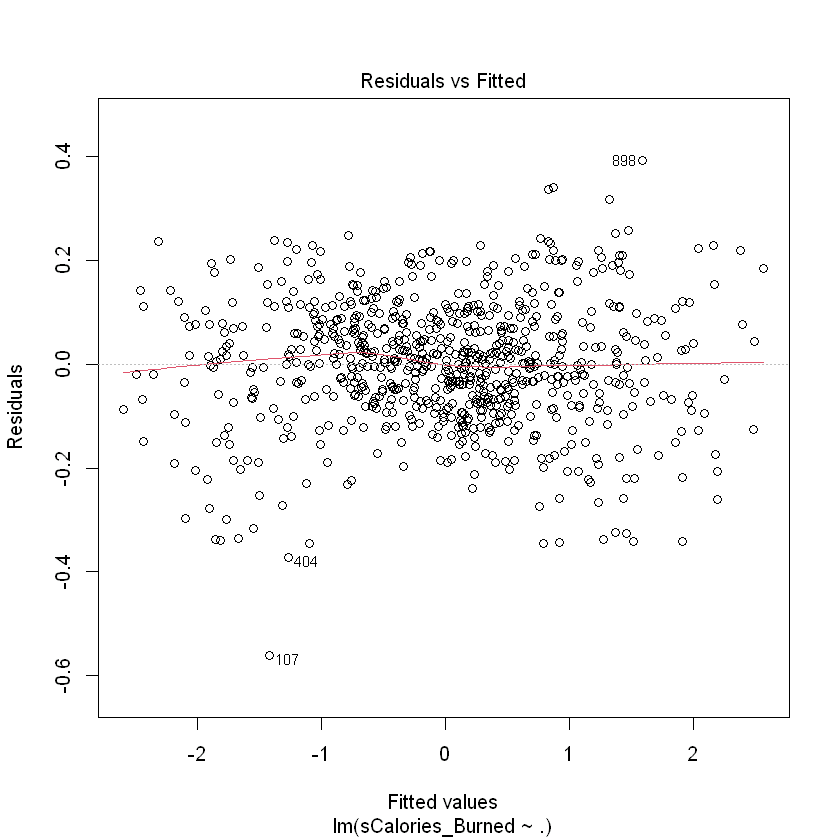

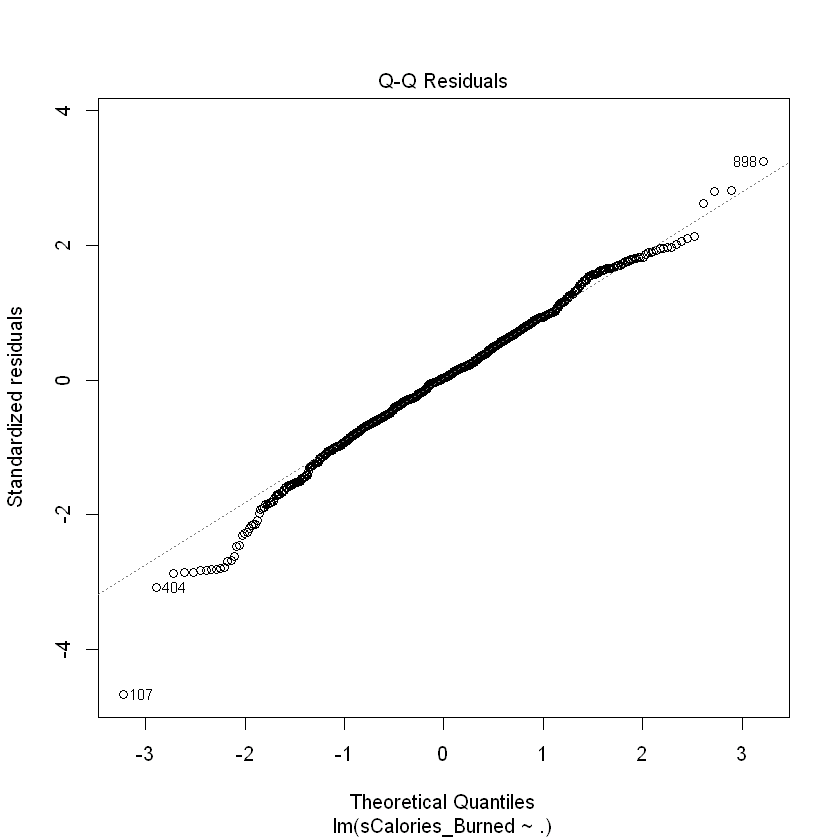

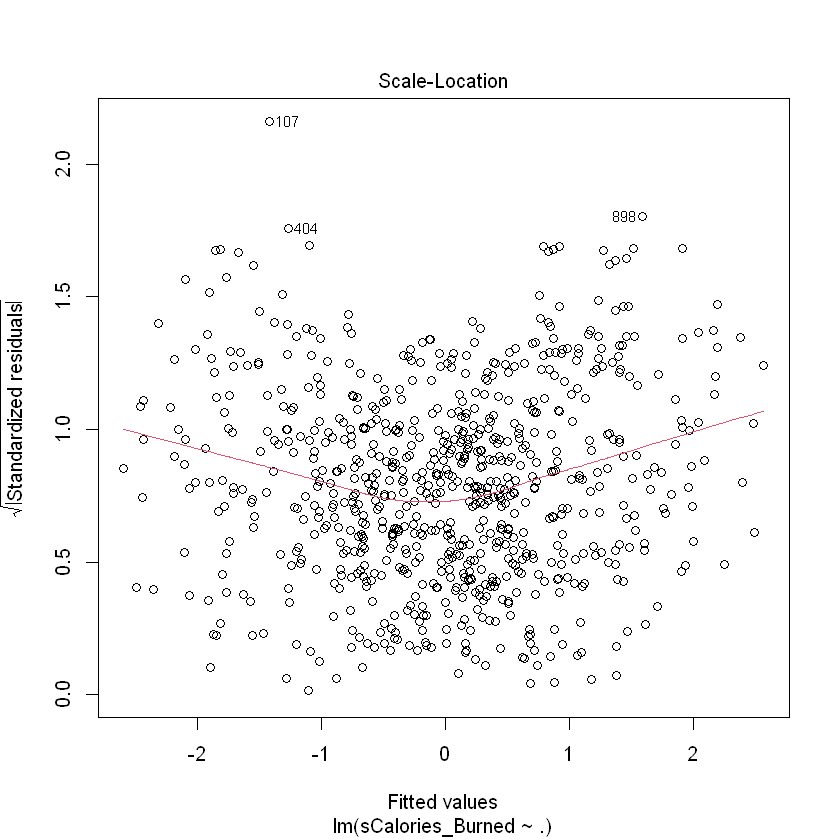

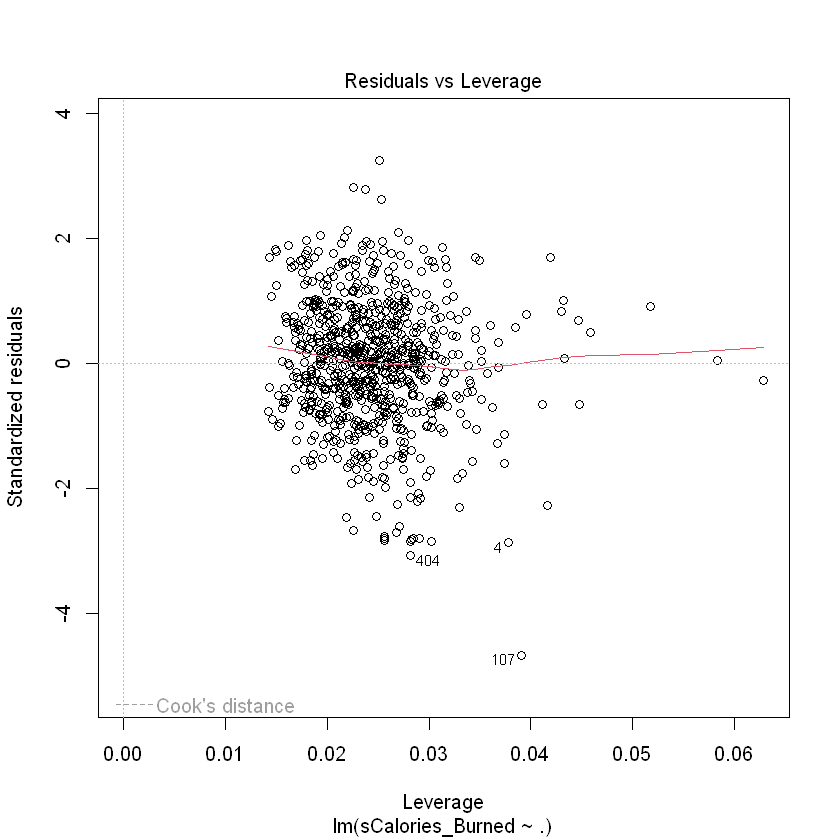

In [ ]:
# On fit un modèle linéaire sans intéractions:
reg = lm(sCalories_Burned ~ ., data = datappr)

summary(reg)
plot(reg)

Le adjusted R-square du modèle est très bon avec une valeur de 0.985. Les coefficients les plus pertinents selon le sommaire sont l'age, le genre, la durée de la session et le BPM moyen (et l'intercept). 

Au niveau des résidus, les hypothèses du modèle linéaire semblent plutôt respectées.

In [144]:
prediction <- predict(reg, newdata = datestr)
rmse <- sqrt(mean((datestr$sCalories_Burned - prediction)^2))
print(rmse)

[1] 0.1275748


le RMSE est assez faible, les prédictions du modèle sont donc plutôt bonnes

### modèle linéaire avec pénalisation lasso

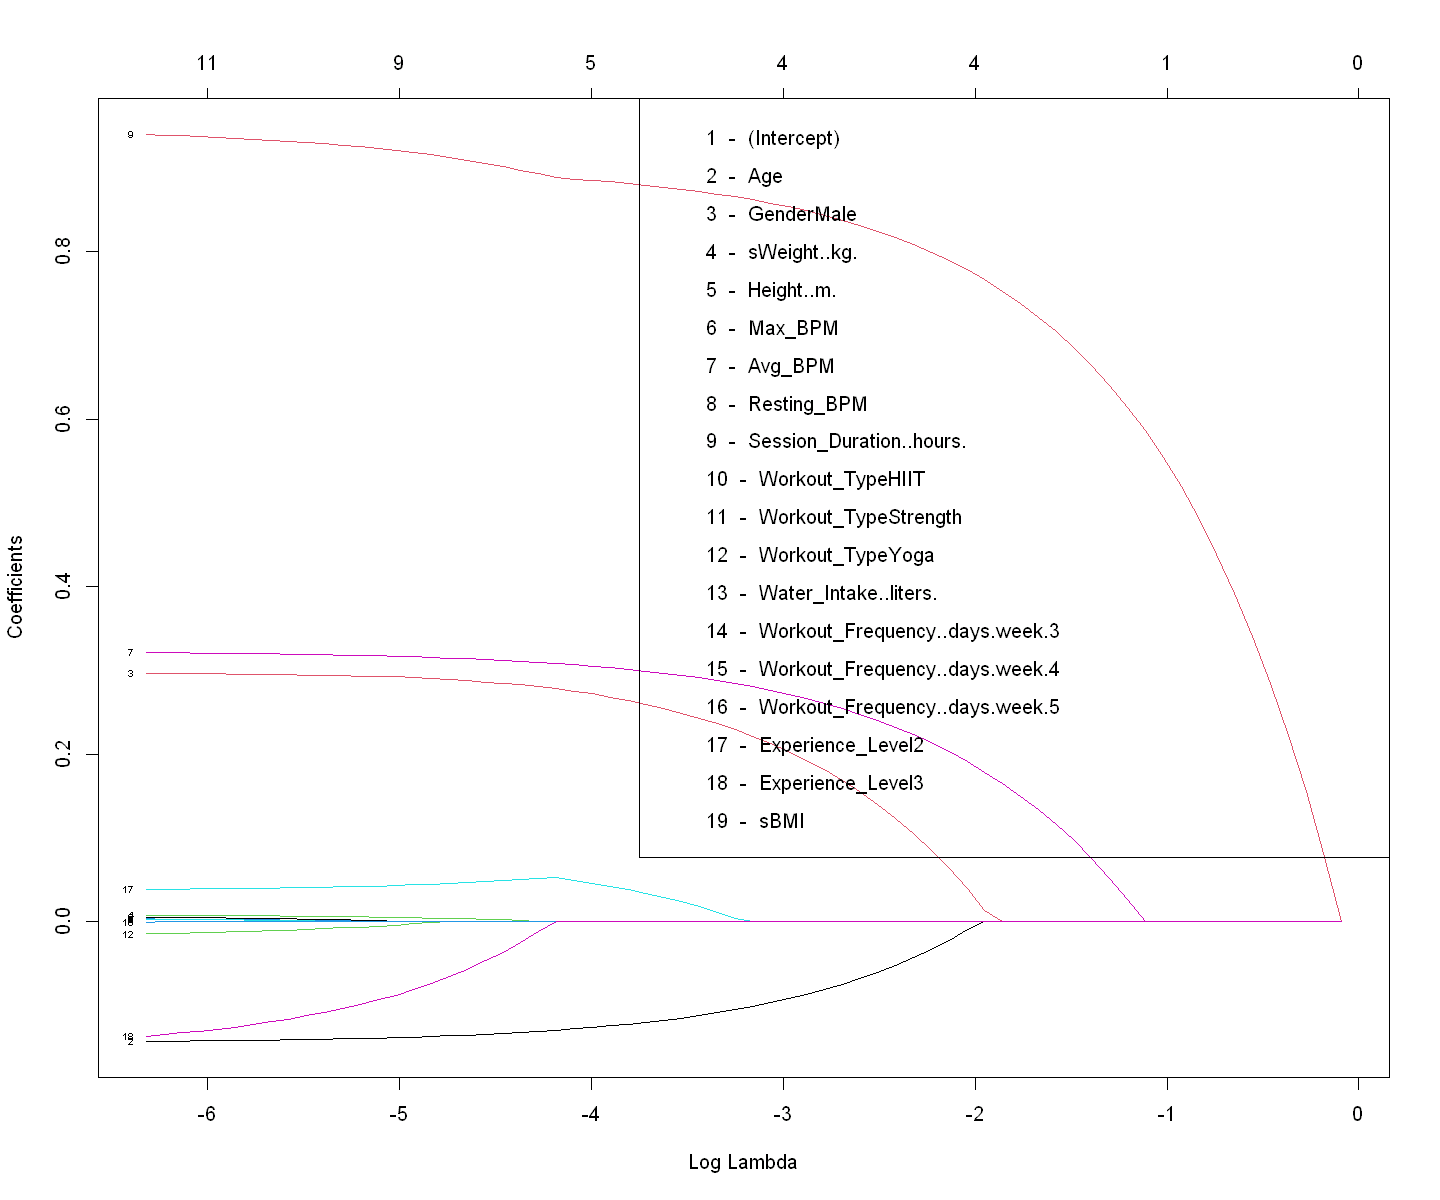

In [164]:
# model matrix permet de transformer les variables qualitatives en variables dummy
x.mat <- model.matrix(sCalories_Burned ~ . , data = datappr)
x.mat_test <- model.matrix(sCalories_Burned ~ . , data = datestr)

# on affiche les chemins de régularisation des variables lasso
reg.lasso <- glmnet(y = datappr$sCalories_Burned, x = x.mat)
options(repr.plot.width = 12, repr.plot.height = 10)
plot(reg.lasso, xvar = "lambda", label = TRUE)
legend("topright", 
       legend = paste(1:ncol(x.mat), " - ", colnames(x.mat)))

On voit que les coefficients gardés sont en partie les mêmes que ceux qui étaient jugés les plus importants par le modèle linéaire (dans l'ordre: age, genre, poids). Cependan, certaines variables comme la taille et le BPM maximal sont ici jugées plus importantes que le BPM moyen et la durée de la session qui étaient jugées plus importantes précèdement.

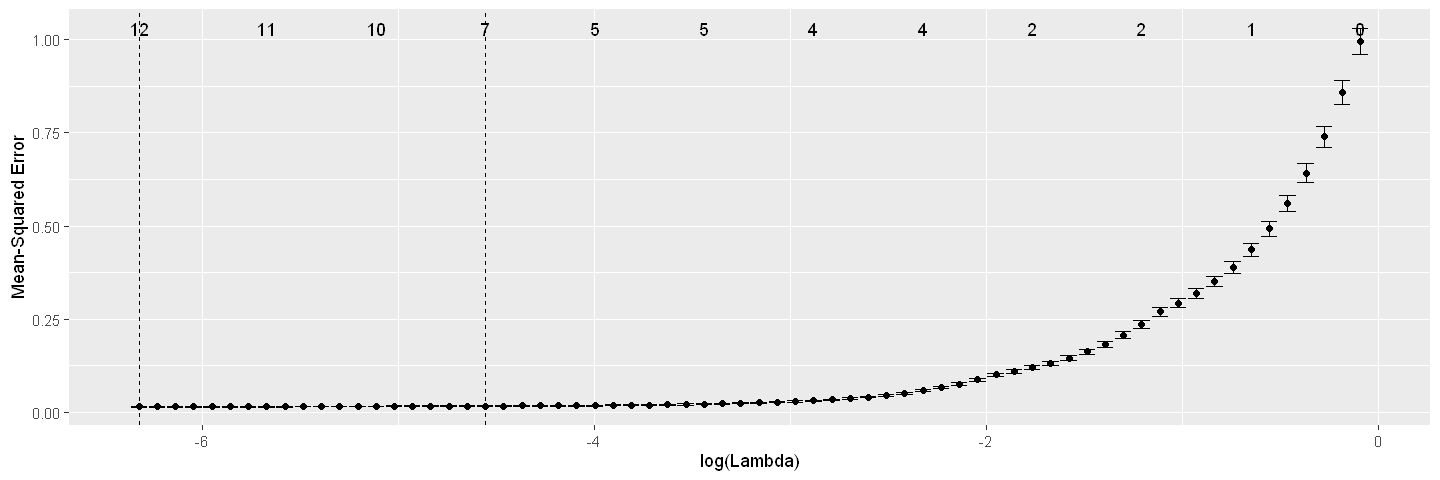

In [163]:
# On affiche ici le MSE du modèle en fonction de log(Lambda) sur les données d'apprentissage

reg.lasso.cv <- cv.glmnet(y = datappr$sCalories_Burned, x = x.mat)
autoplot(reg.lasso.cv)

On remarque que le modèle à de meilleurs résultats avec un coefficient lambda petit (log(lambda) entre -6 et -3 environ), c'est à dire en ayant un modèle proche du modèle linéaire. On peut donc questionner l'utilité d'utiliser la pénalisation lasso ici.

In [159]:
lambda_min <- reg.lasso.cv$lambda.min
y <- datappr$sCalories_Burned
modelmin <- glmnet(x = x.mat, y = y, lambda = lambda_min, standardize = FALSE)

y_pred_min <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat)

rmse <- sqrt(mean((y - y_pred_min)^2))

ss_res <- sum((y - y_pred_min)^2)
ss_tot <- sum((y - mean(y))^2)
r2 <- 1 - ss_res / ss_tot

cat("Lambda:", lambda_min, "\n")
cat("RMSE:", round(rmse, 4), "\n")
cat("R²:", round(r2, 4), "\n")
print(coef(reg.lasso.cv, s = "lambda.min"))

Lambda: 0.001971438 
RMSE: 0.1212 
R²: 0.9853 
20 x 1 sparse Matrix of class "dgCMatrix"
                                          s1
(Intercept)                    -0.1432147783
(Intercept)                     .           
Age                            -0.1426936803
GenderMale                      0.2964683997
sWeight..kg.                    0.0078719115
Height..m.                      0.0031529272
Max_BPM                         0.0030825077
Avg_BPM                         0.3212947718
Resting_BPM                     0.0054083336
Session_Duration..hours.        0.9394253135
Workout_TypeHIIT                .           
Workout_TypeStrength            .           
Workout_TypeYoga               -0.0141734401
Water_Intake..liters.           .           
Workout_Frequency..days.week.3  .           
Workout_Frequency..days.week.4  .           
Workout_Frequency..days.week.5 -0.0001952406
Experience_Level2               0.0388249075
Experience_Level3              -0.1347606435
sBMI       

Le RMSE est très faiblement meilleur que pour le modèle linéaire et le R-square est un peu moins bon (mais cv.glmnet optimise lambda pour avoir le meilleur RMSE possible donc c'est cohérent). 

On conserve 13 coefficients non nuls

In [ ]:
#On ré-itére en utilisant le lambda 1se qui est plus grand mais à une erreur similaire à un écart-type près, cela permet d'utiliser moins de variables

lambda_1se <- reg.lasso.cv$lambda.1se
model1se <- glmnet(x = x.mat, y = y, lambda = lambda_1se, standardize = FALSE)

y_pred_1se <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat)

rmse <- sqrt(mean((y - y_pred_1se)^2))

ss_res <- sum((y - y_pred_1se)^2)
ss_tot <- sum((y - mean(y))^2)
r2 <- 1 - ss_res / ss_tot

cat("Lambda:", lambda_1se, "\n")
cat("RMSE:", round(rmse, 4), "\n")
cat("R²:", round(r2, 4), "\n")

print(coef(reg.lasso.cv, s = "lambda.1se"))


Lambda: 0.01052097 
RMSE: 0.1265 
R²: 0.984 
20 x 1 sparse Matrix of class "dgCMatrix"
                                         s1
(Intercept)                    -0.161818949
(Intercept)                     .          
Age                            -0.134455822
GenderMale                      0.286260944
sWeight..kg.                    0.002773115
Height..m.                      .          
Max_BPM                         .          
Avg_BPM                         0.313206927
Resting_BPM                     .          
Session_Duration..hours.        0.906183076
Workout_TypeHIIT                .          
Workout_TypeStrength            .          
Workout_TypeYoga                .          
Water_Intake..liters.           .          
Workout_Frequency..days.week.3  .          
Workout_Frequency..days.week.4  .          
Workout_Frequency..days.week.5  .          
Experience_Level2               0.047833324
Experience_Level3              -0.046772499
sBMI                            .

Les performances sont comparables bien que un peu moins bonne mais on utilise 5 coefficients de moins.

### Comparaison sur l'échantillon de test:

In [168]:
y_test <- datestr$sCalories_Burned

test_1se <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat_test)
test_min <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat_test)

rmse_1se <- sqrt(mean((y_test - test_1se)^2))
rmse_min <- sqrt(mean((y_test - test_min)^2))

cat("RMSE pour lambda.min :", rmse_min, "\n")
cat("RMSE pour lambda.1se :", rmse_1se, "\n")

RMSE pour lambda.min : 0.1281096 
RMSE pour lambda.1se : 0.1357074 


Comme attendu, les résultats sont un peu moins bon que sur les données d'apprentissage mais restent comparables

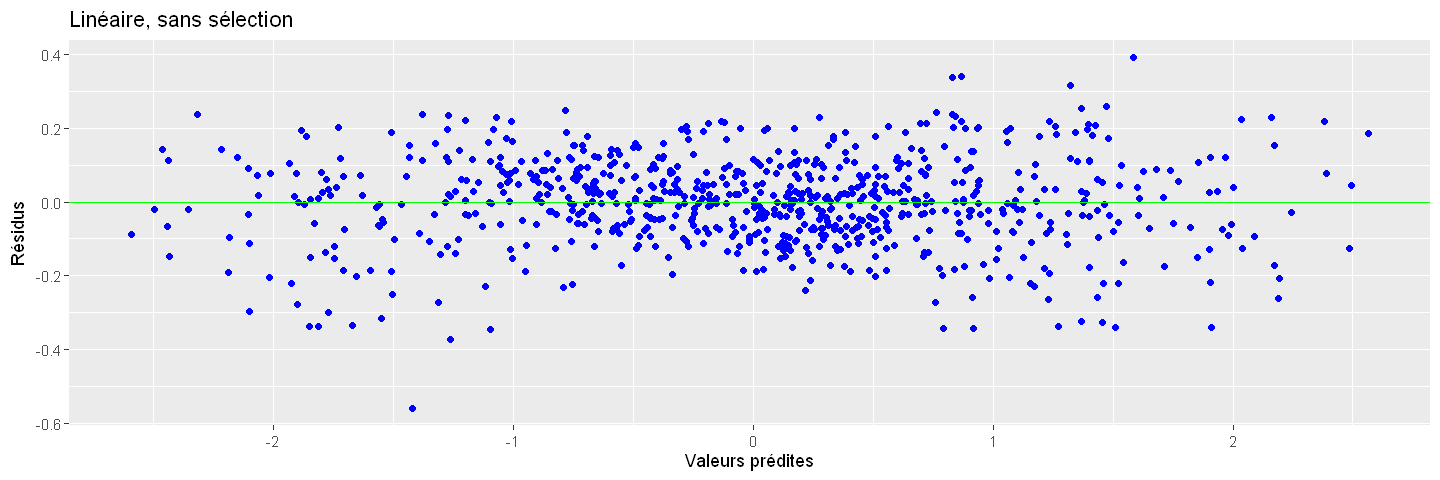

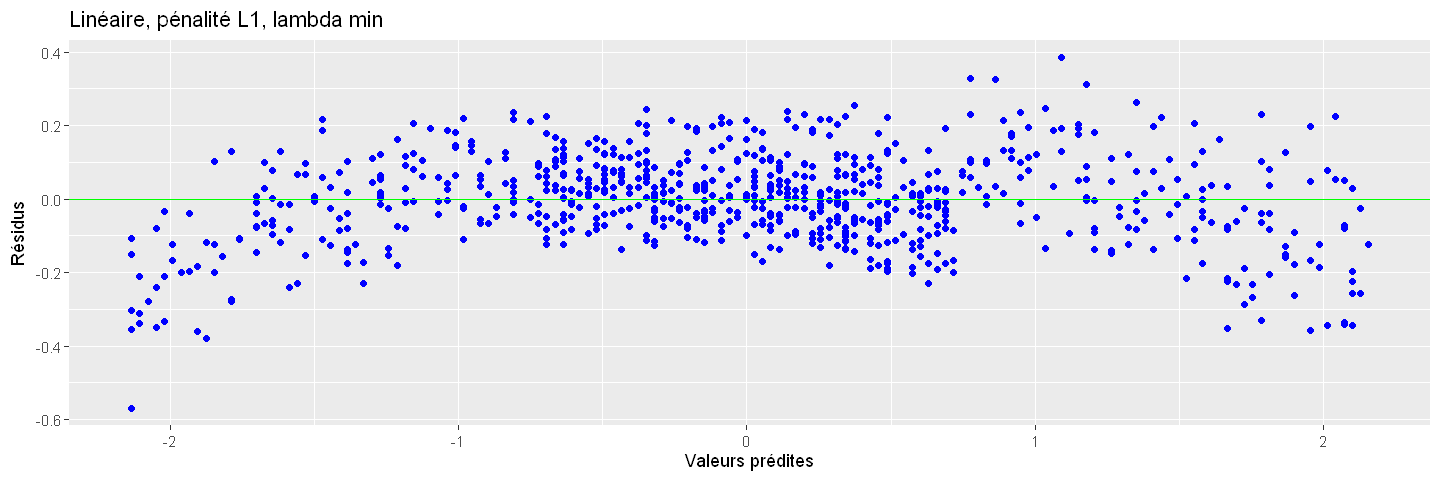

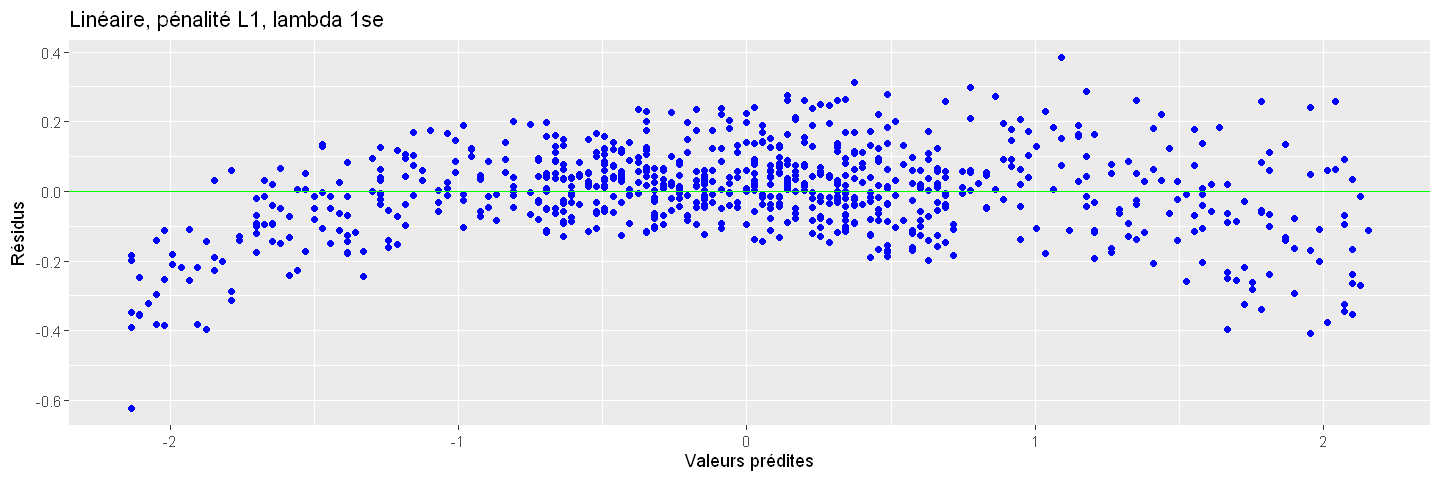

In [161]:
res.lasso <- y - y_pred_min
res.lasso.1se <- y - y_pred_1se 

# Graphe des résidus
options(repr.plot.width = 12, repr.plot.height = 4)
par(mfrow = c(1, 3))
gplot.res(fit.lm, res.lm, "Linéaire, sans sélection")
gplot.res(fit.lasso, res.lasso, "Linéaire, pénalité L1, lambda min")
gplot.res(fit.lasso.1se, res.lasso.1se, "Linéaire, pénalité L1, lambda 1se") 



### modèle linéaire avec interactions d'ordre 2

On utilise ici un modèle linéaire avec les interactions d'ordre 2. On utilise la méthode backward pour la sélection des variables. On compare les résultats avec 2 critères différents: AIC et BIC

In [172]:
# Modèle avec toutes les interactions d'ordre 2
reg.glm <- glm(sCalories_Burned ~ .^2, data = datappr)

# Selection de modèle backward avec AIC et BIC:
reg.glm.step.aic <- step(reg.glm, direction = "backward")


Start:  AIC=-1327.56
sCalories_Burned ~ (Age + Gender + sWeight..kg. + Height..m. + 
    Max_BPM + Avg_BPM + Resting_BPM + Session_Duration..hours. + 
    Workout_Type + Water_Intake..liters. + Workout_Frequency..days.week. + 
    Experience_Level + sBMI)^2


Step:  AIC=-1327.56
sCalories_Burned ~ Age + Gender + sWeight..kg. + Height..m. + 
    Max_BPM + Avg_BPM + Resting_BPM + Session_Duration..hours. + 
    Workout_Type + Water_Intake..liters. + Workout_Frequency..days.week. + 
    Experience_Level + sBMI + Age:Gender + Age:sWeight..kg. + 
    Age:Height..m. + Age:Max_BPM + Age:Avg_BPM + Age:Resting_BPM + 
    Age:Session_Duration..hours. + Age:Workout_Type + Age:Water_Intake..liters. + 
    Age:Workout_Frequency..days.week. + Age:Experience_Level + 
    Age:sBMI + Gender:sWeight..kg. + Gender:Height..m. + Gender:Max_BPM + 
    Gender:Avg_BPM + Gender:Resting_BPM + Gender:Session_Duration..hours. + 
    Gender:Workout_Type + Gender:Water_Intake..liters. + Gender:Workout_Frequency..da

In [173]:
n <- nrow(datappr)
reg.glm.step.bic <- step(reg.glm, direction = "backward", k = log(n))

Start:  AIC=-596.45
sCalories_Burned ~ (Age + Gender + sWeight..kg. + Height..m. + 
    Max_BPM + Avg_BPM + Resting_BPM + Session_Duration..hours. + 
    Workout_Type + Water_Intake..liters. + Workout_Frequency..days.week. + 
    Experience_Level + sBMI)^2


Step:  AIC=-596.45
sCalories_Burned ~ Age + Gender + sWeight..kg. + Height..m. + 
    Max_BPM + Avg_BPM + Resting_BPM + Session_Duration..hours. + 
    Workout_Type + Water_Intake..liters. + Workout_Frequency..days.week. + 
    Experience_Level + sBMI + Age:Gender + Age:sWeight..kg. + 
    Age:Height..m. + Age:Max_BPM + Age:Avg_BPM + Age:Resting_BPM + 
    Age:Session_Duration..hours. + Age:Workout_Type + Age:Water_Intake..liters. + 
    Age:Workout_Frequency..days.week. + Age:Experience_Level + 
    Age:sBMI + Gender:sWeight..kg. + Gender:Height..m. + Gender:Max_BPM + 
    Gender:Avg_BPM + Gender:Resting_BPM + Gender:Session_Duration..hours. + 
    Gender:Workout_Type + Gender:Water_Intake..liters. + Gender:Workout_Frequency..days

In [174]:
# Coefficients AIC
anova(reg.glm.step.aic, test = "F")

,Df,Deviance,Resid. Df,Resid. Dev,F,Pr(>F)
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
NULL,NA,NA,777,777.000000,NA,NA
Age,1,1.751784e+01,776,759.482165,2.070466e+03,2.524902e-213
Gender,1,1.388761e+01,775,745.594551,1.641404e+03,2.443641e-187
sWeight..kg.,1,1.481974e-02,774,745.579731,1.751574e+00,1.861020e-01
Height..m.,1,6.123356e-02,773,745.518498,7.237312e+00,7.307037e-03
Max_BPM,1,2.649288e-01,772,745.253569,3.131244e+01,3.130616e-08
Avg_BPM,1,1.006615e+02,771,644.592093,1.189737e+04,0.000000e+00
Resting_BPM,1,5.665400e-01,770,644.025553,6.696044e+01,1.267432e-15
Session_Duration..hours.,1,6.302510e+02,769,13.774542,7.449057e+04,0.000000e+00


In [175]:
# Coefficients BIC
anova(reg.glm.step.bic, test = "F")

,Df,Deviance,Resid. Df,Resid. Dev,F,Pr(>F)
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
NULL,NA,NA,777,777.000000,NA,NA
Age,1,17.51783506,776,759.482165,1892.209073,1.095555e-208
Gender,1,13.88761407,775,745.594551,1500.086583,3.210392e-182
Avg_BPM,1,100.18180197,774,645.412749,10821.252395,0.000000e+00
Resting_BPM,1,0.51921606,773,644.893533,56.083719,1.924395e-13
Session_Duration..hours.,1,631.06121916,772,13.832314,68164.802337,0.000000e+00
Experience_Level,2,2.32619647,770,11.506117,125.633391,6.983516e-48
sBMI,1,0.02523429,769,11.480883,2.725711,9.915620e-02
Age:Session_Duration..hours.,1,0.33040794,768,11.150475,35.689393,3.550080e-09


Le nombre de coefficients sélectionnés par le critère est bien plus faible (ce qui est logique car comme log(n)>2 ici, la pénalisation est plus forte pour BIC).

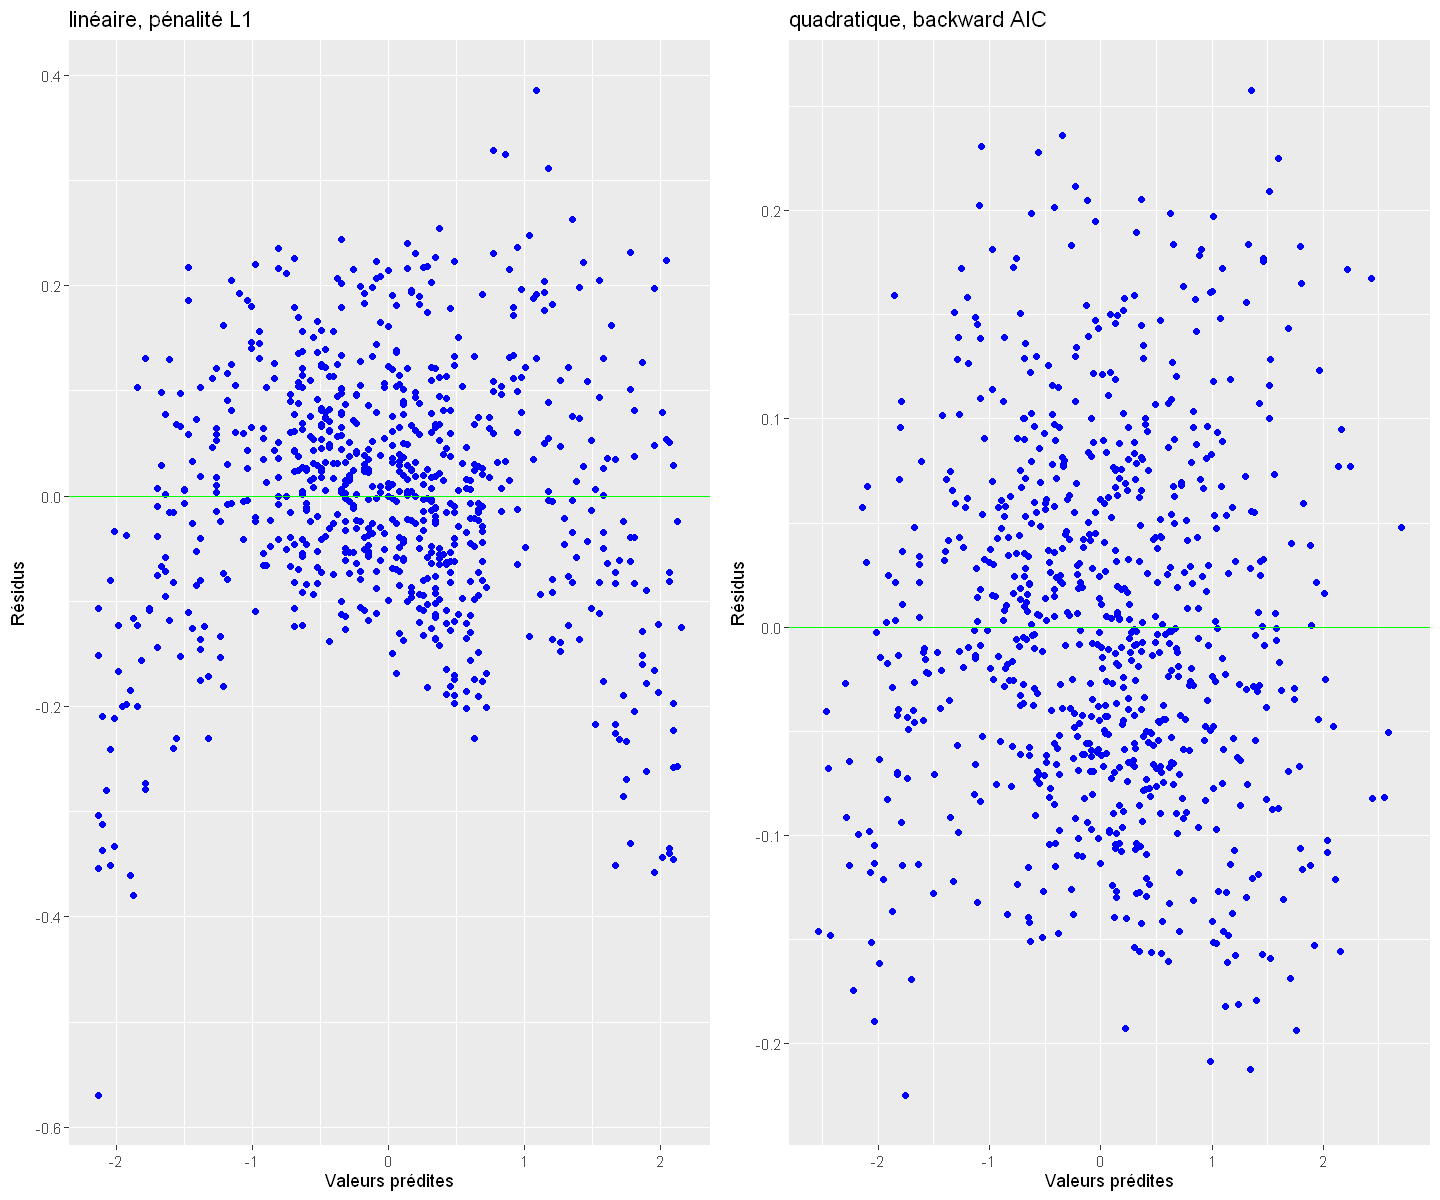

In [176]:
# Extraction des valeurs ajustées et des résidus
fit.glm.aic <- reg.glm.step.aic$fitted.values
res.glm.aic <- reg.glm.step.aic$residuals
fit.glm.bic <- reg.glm.step.bic$fitted.values
res.glm.bic <- reg.glm.step.bic$residuals


# Graphe des résidus
g1<-gplot.res(fit.lasso, res.lasso, "linéaire, pénalité L1")
g2<-gplot.res(fit.glm, res.glm, "quadratique, backward AIC")
grid.arrange(g1,g2,ncol=2)

### résultats sur l'échantillon de test

In [181]:
# Comparaison des RMSE:

y_test <- datestr$sCalories_Burned

test_aic <- predict(reg.glm.step.aic, newdata  = datestr)
test_bic <- predict(reg.glm.step.bic, newdata  = datestr)

rmse_aic <- sqrt(mean((y_test - test_aic)^2))
rmse_bic <- sqrt(mean((y_test - test_bic)^2))

cat("RMSE pour AIC :", rmse_aic, "\n")
cat("RMSE pour BIC :", rmse_bic, "\n")


RMSE pour AIC : 0.1063492 
RMSE pour BIC : 0.09793335 


Les résultats sont meilleurs que pour le modèle linéaire classique ou celui avec pénalisation lasso. Cependant les modèles sont plus complexes

On remarque aussi que le modèle dont on a fait la sélection en suivant le critère BIC est meilleur alors qu'il utilise beaucoup moins de variables. Il est donc préférable de l'utiliser.

## 2.1.3 Régression par SVM

On réalise une SVM sur les données pour la regression, on commence par rechercher les paramètres optimaux:

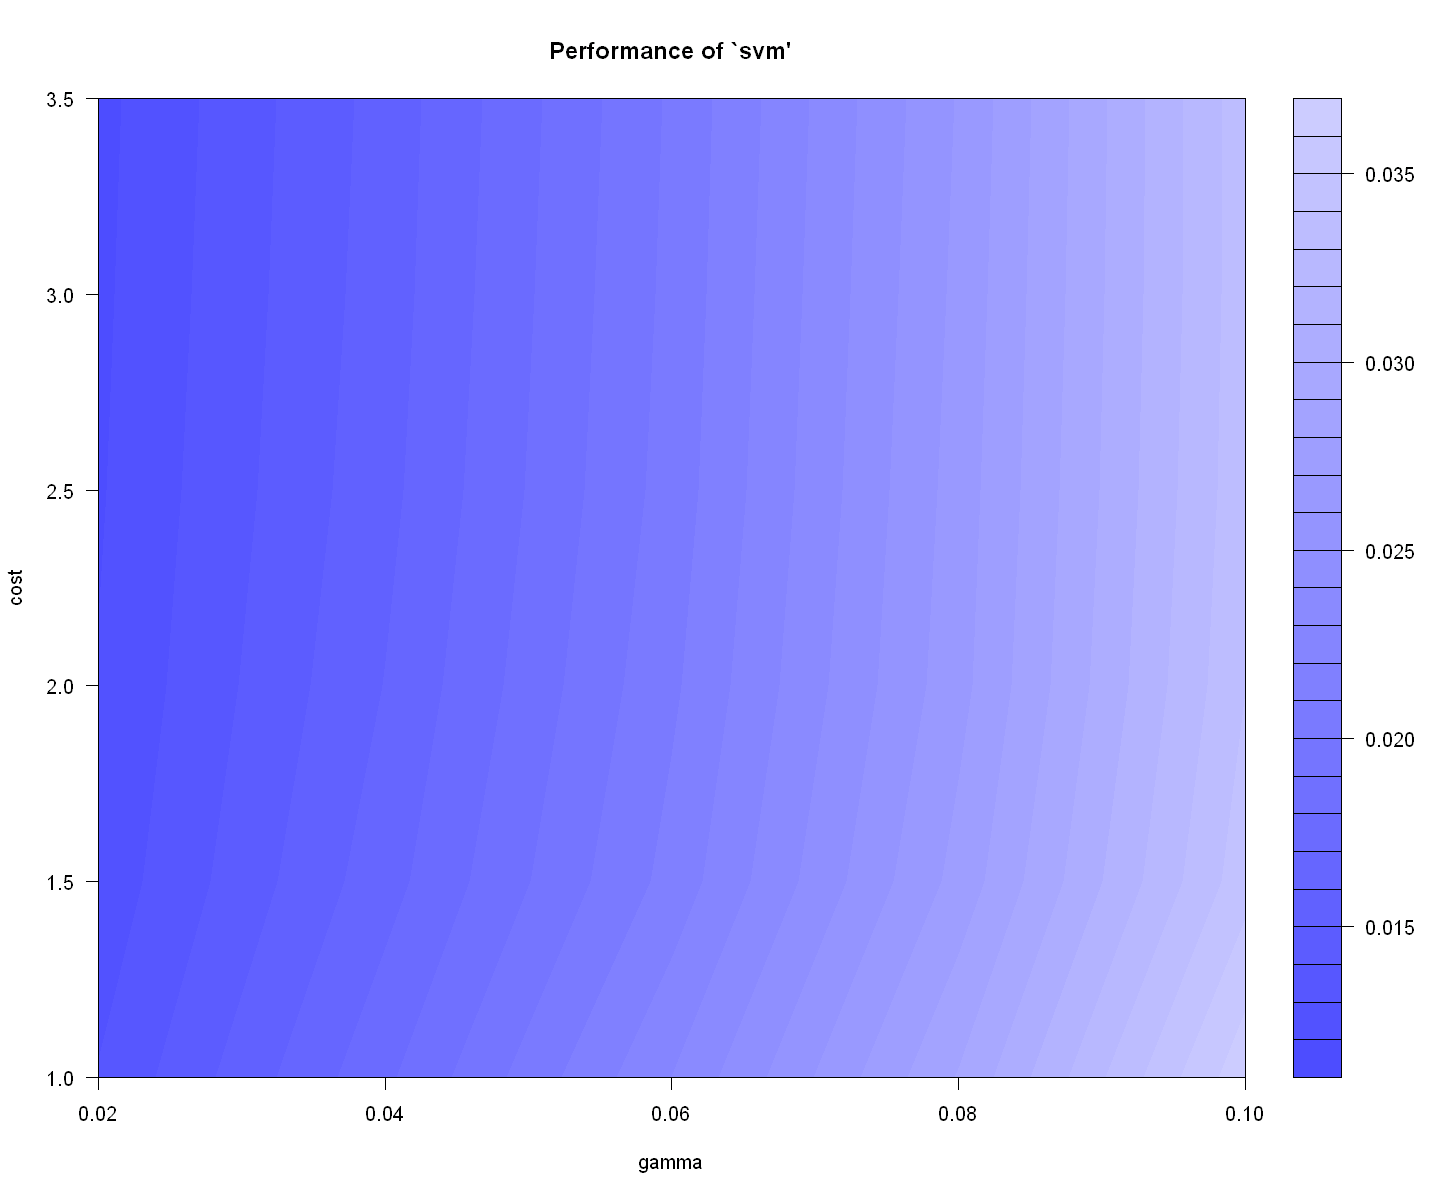

In [183]:
# Recherche des paramètres optimaux pour gamma et le coût (RMSE minimal):

svm.reg.tune = tune.svm(sCalories_Burned ~ ., data = datappr, cost = c(1, 1.5, 2, 2.5, 3, 3.5), 
    gamma = seq(0.02, 0.1, by = 0.02))
plot(svm.reg.tune)

In [184]:

# On fit le modèle avec les paramètres optimisés pour RMSE:

svm.reg = svm(sCalories_Burned ~ ., data = datappr, cost = svm.reg.tune$best.parameters$cost, 
    gamma = svm.reg.tune$best.parameters$gamma)
summary(svm.reg)


Call:
svm(formula = sCalories_Burned ~ ., data = datappr, cost = svm.reg.tune$best.parameters$cost, 
    gamma = svm.reg.tune$best.parameters$gamma)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  3.5 
      gamma:  0.02 
    epsilon:  0.1 


Number of Support Vectors:  259






Les paramètres optimaux utilisés sont: cost = 3.5, gamma = 0.02

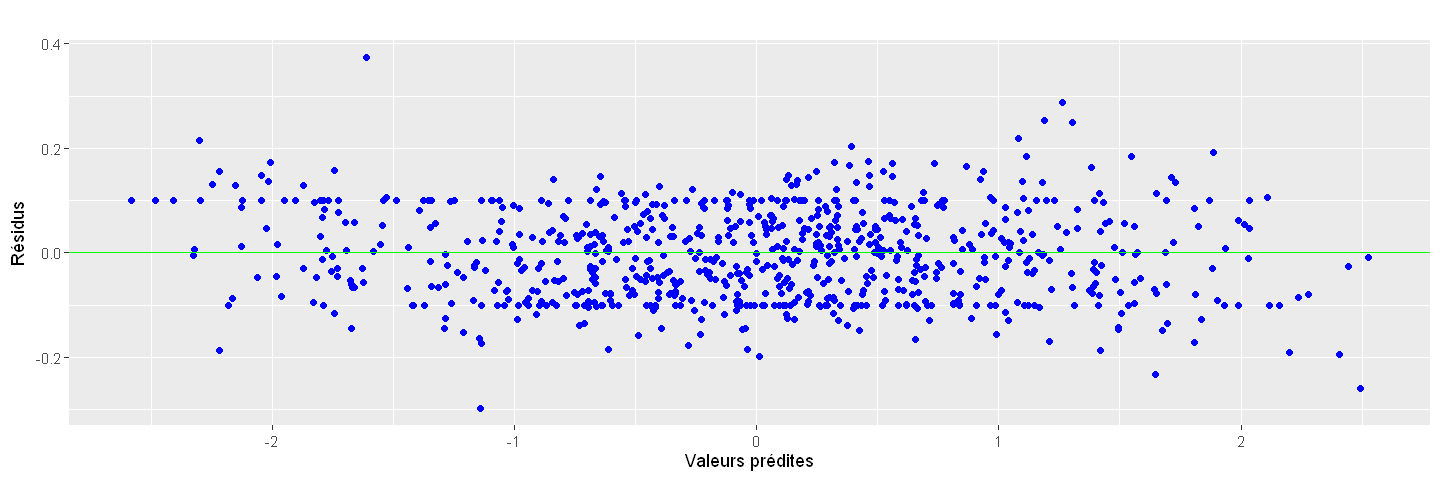

In [86]:
fit.svmr=fit.svmr=svm.reg$fitted
res.svmr=fit.svmr-datappr[,"sCalories_Burned"]
gplot.res(fit.svmr,res.svmr,titre="")

### RMSE sur l'échantillon de test:

In [215]:
test_svmr <- predict(svm.reg,newdata=datestr)

rmse_svmr <- sqrt(mean((y_test - test_svmr)^2))

cat("RMSE pour SVMR :", rmse_svmr, "\n")

RMSE pour SVMR : 0.1102439 


## 2.1.3 CART pour régression

Pour obtenir un arbre CART qui ne soit pas sur-entraîné on fait de la validation croisé sur l'échantillon d'apprentissage:

On optimise le paramètre de complexité cp

In [ ]:
#tree.reg=rpart(sCalories_Burned~.,data=datappr,control=rpart.control(cp=0.001))

In [187]:
#options(repr.plot.width = 15, repr.plot.height = 10)
#rpart.plot(tree.reg)

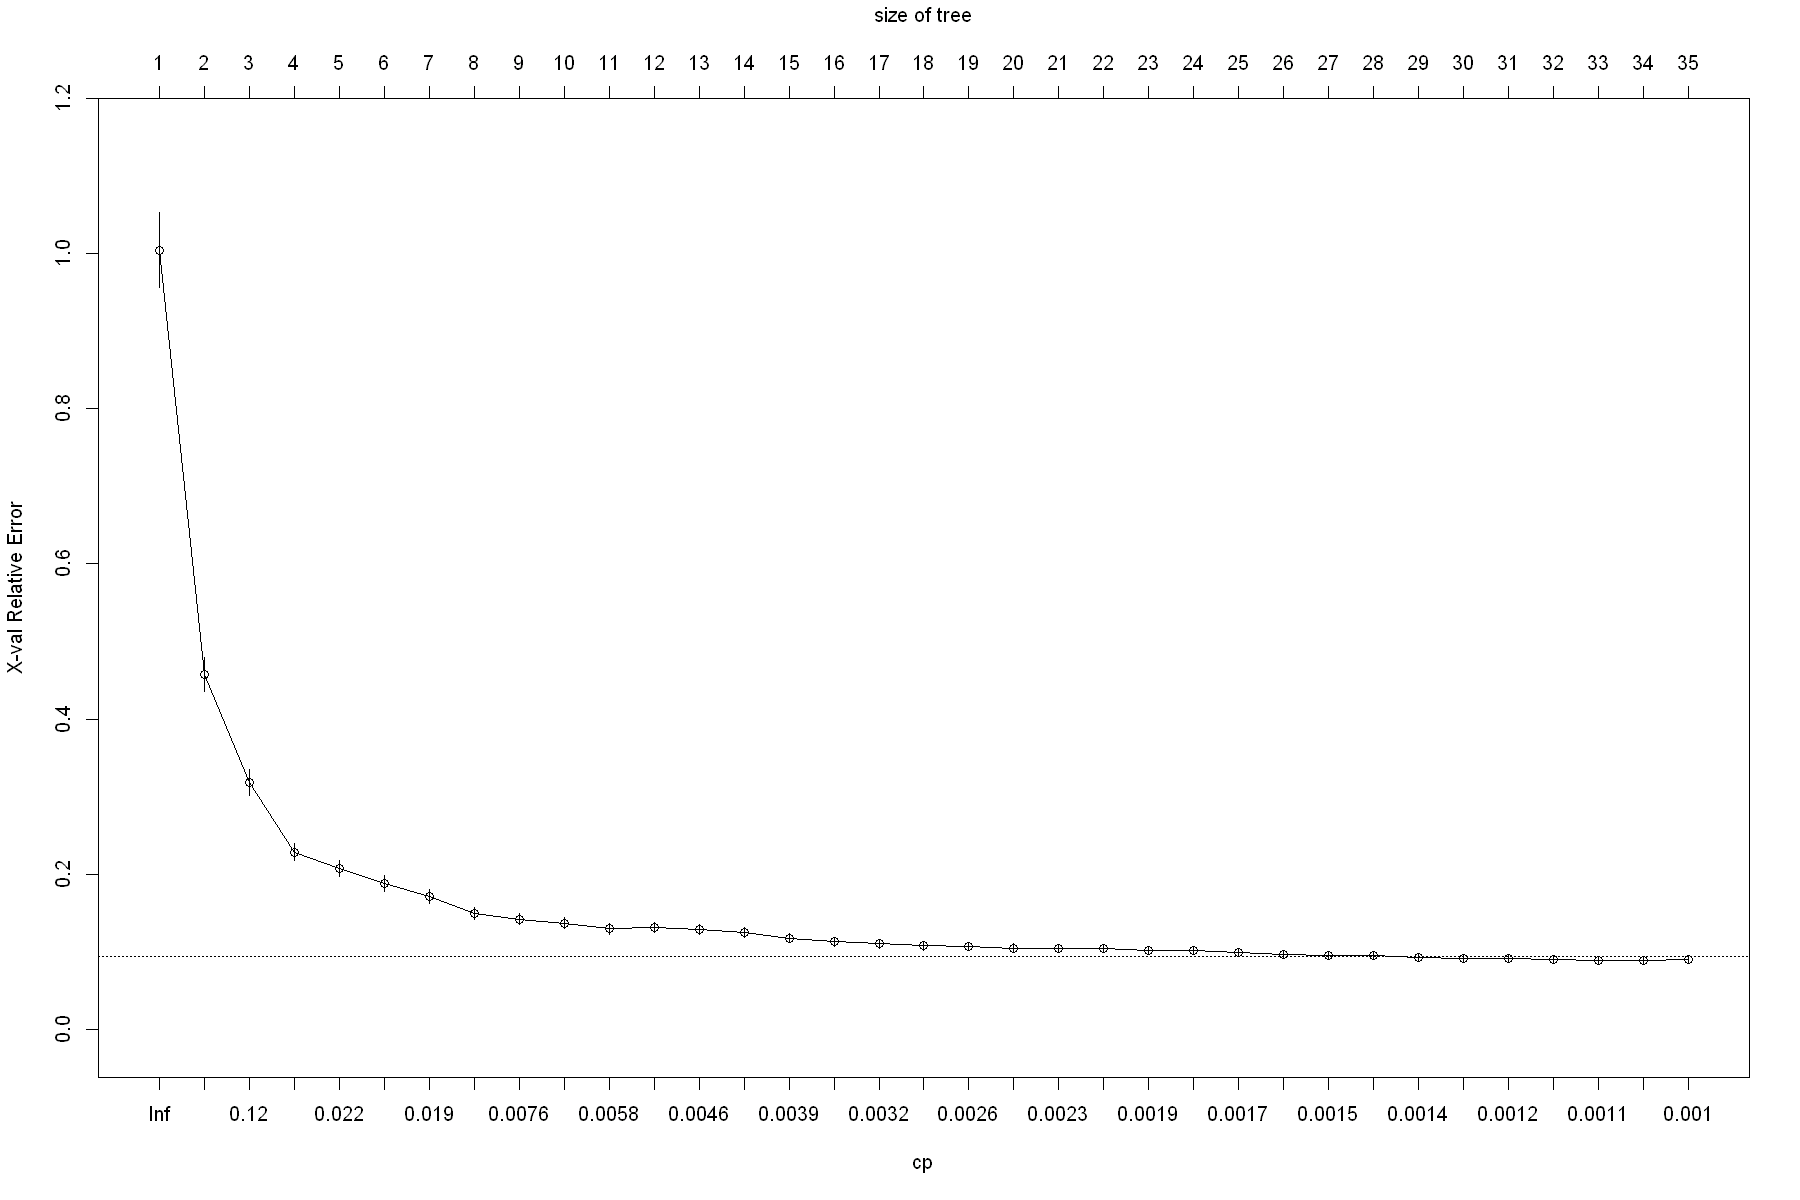

In [ ]:
# entrainement par validation croisée
xmat<-xpred.rpart(tree.reg,xval=10) 
CVerr<-apply((xmat-datappr[,"sCalories_Burned"])^2,2,sum)

# affichage de l'erreur selon la taille de l'arbre
plotcp(tree.reg)

les arbres avec les meilleurs résultats semblent toujours être les arbres très complexes.

cp optimal : 0.001051002 


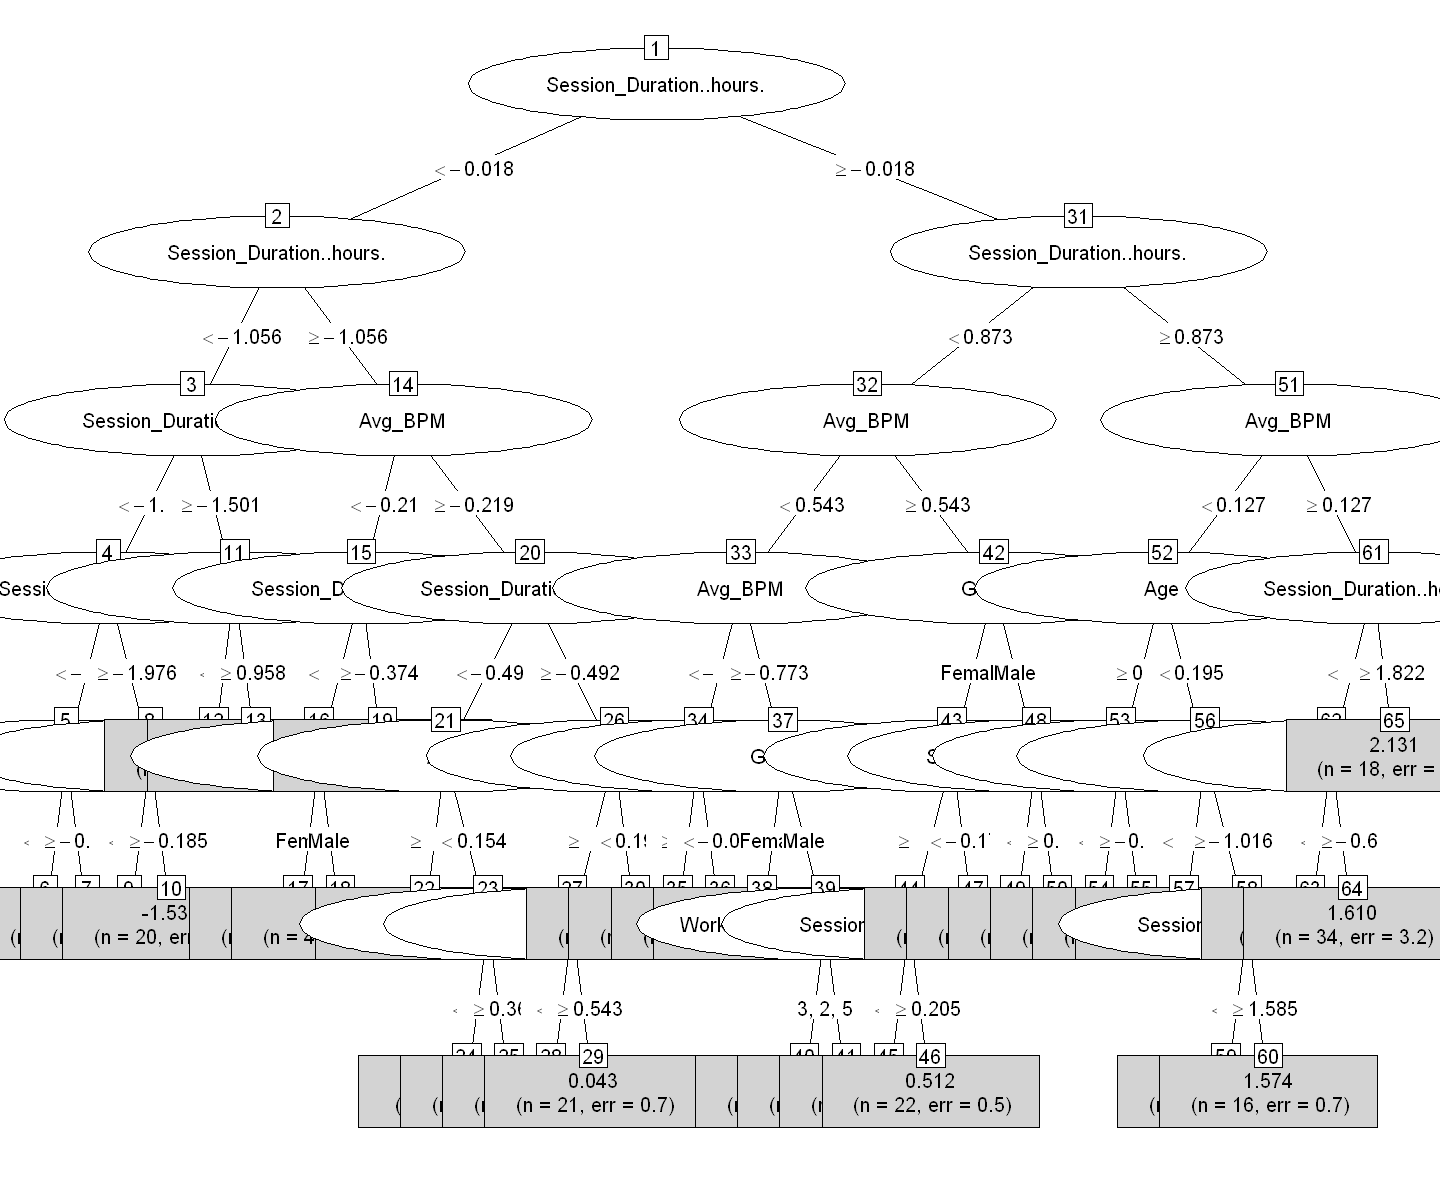

In [191]:
# On utilise la valeur de cp qui donne la plus petite erreur:

cp.opt = as.numeric(attributes(which.min(CVerr))$names)

cat("cp optimal :", cp.opt, "\n")
tree.reg=rpart(sCalories_Burned~.,data=datappr,control=rpart.control(cp=cp.opt))

# affichage plus clair avec partykit (l'arbre reste illisible mais vu la taille il est difficile de faire mieux)
plot(as.party(tree.reg), type="simple")

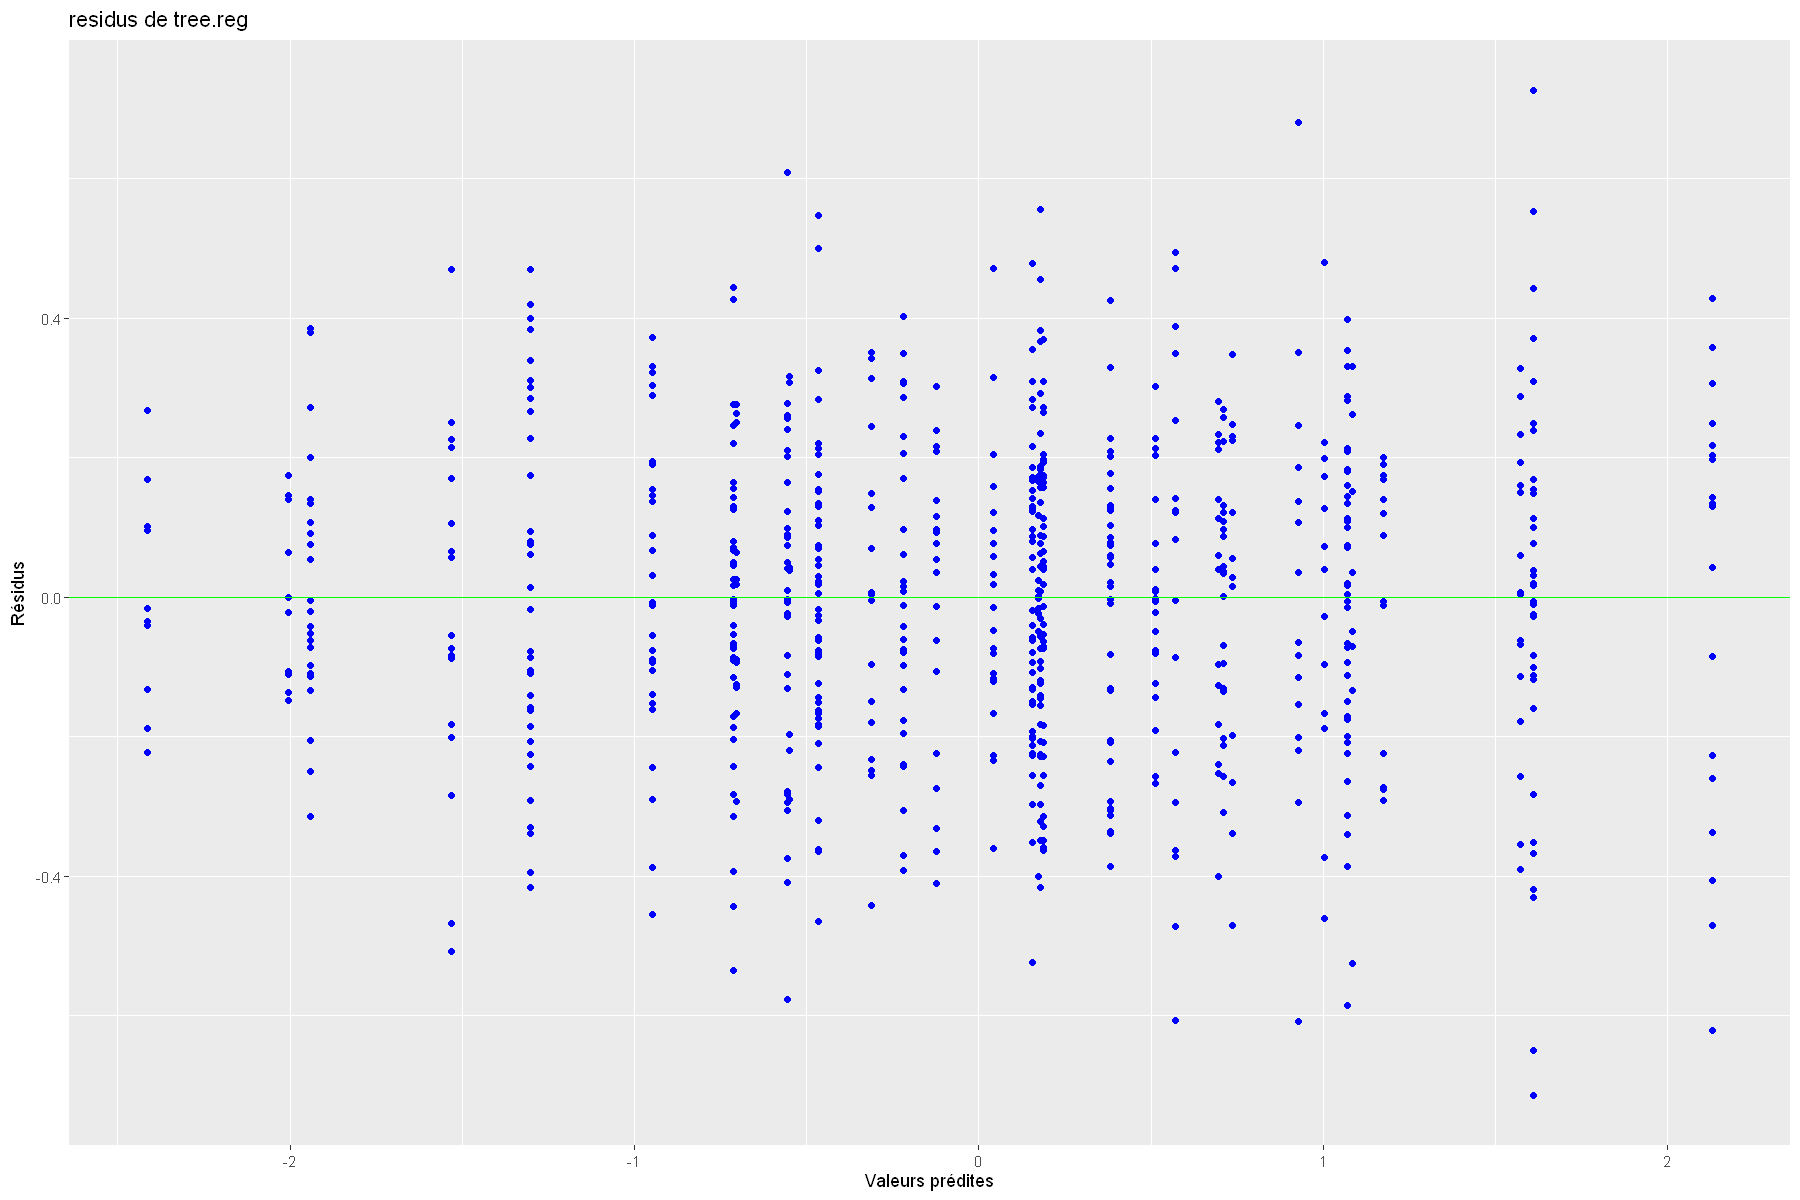

In [ ]:
# On affiche les résidus de l'arbre, on retrouve la structure caractéristique des résidus de CART avec des lignes verticales qui correspondent aux différentes feuilles
fit.tree=predict(tree.reg)
res.tree=fit.tree-datappr[,"sCalories_Burned"]
gplot.res(fit.tree,res.tree,"residus de tree.reg")

### RMSE sur l'échantillon de test

In [214]:
test_tree <- predict(tree.reg,newdata=datestr)

rmse_tree <- sqrt(mean((y_test - test_tree)^2))

cat("RMSE pour CART :", rmse_tree, "\n")

RMSE pour CART : 0.2943752 


## 2.1.4 Agrégation des modèles: 

## Random forest

In [ ]:
#modèle random forest

rf.reg=randomForest(sCalories_Burned~., data=datappr,xtest=datestr[,-9],ytest=datestr[,"sCalories_Burned"],
   ntree=500,do.trace=50,importance=TRUE)

rf.reg$mtry

     |      Out-of-bag   |       Test set    |
Tree |      MSE  %Var(y) |      MSE  %Var(y) |
  50 |  0.05515     5.52 |  0.04524     4.55 |
 100 |  0.05193     5.20 |  0.03948     3.97 |
 150 |  0.05282     5.29 |  0.03988     4.01 |
 200 |  0.05152     5.16 |  0.04056     4.08 |
 250 |  0.05131     5.14 |  0.04025     4.05 |
 300 |  0.04999     5.01 |  0.03897     3.92 |
 350 |  0.04933     4.94 |    0.039     3.92 |
 400 |  0.04915     4.92 |  0.03958     3.98 |
 450 |  0.04918     4.92 |  0.03952     3.97 |
 500 |  0.04884     4.89 |  0.03925     3.95 |


[1] 4

Meilleur mtry : 12 


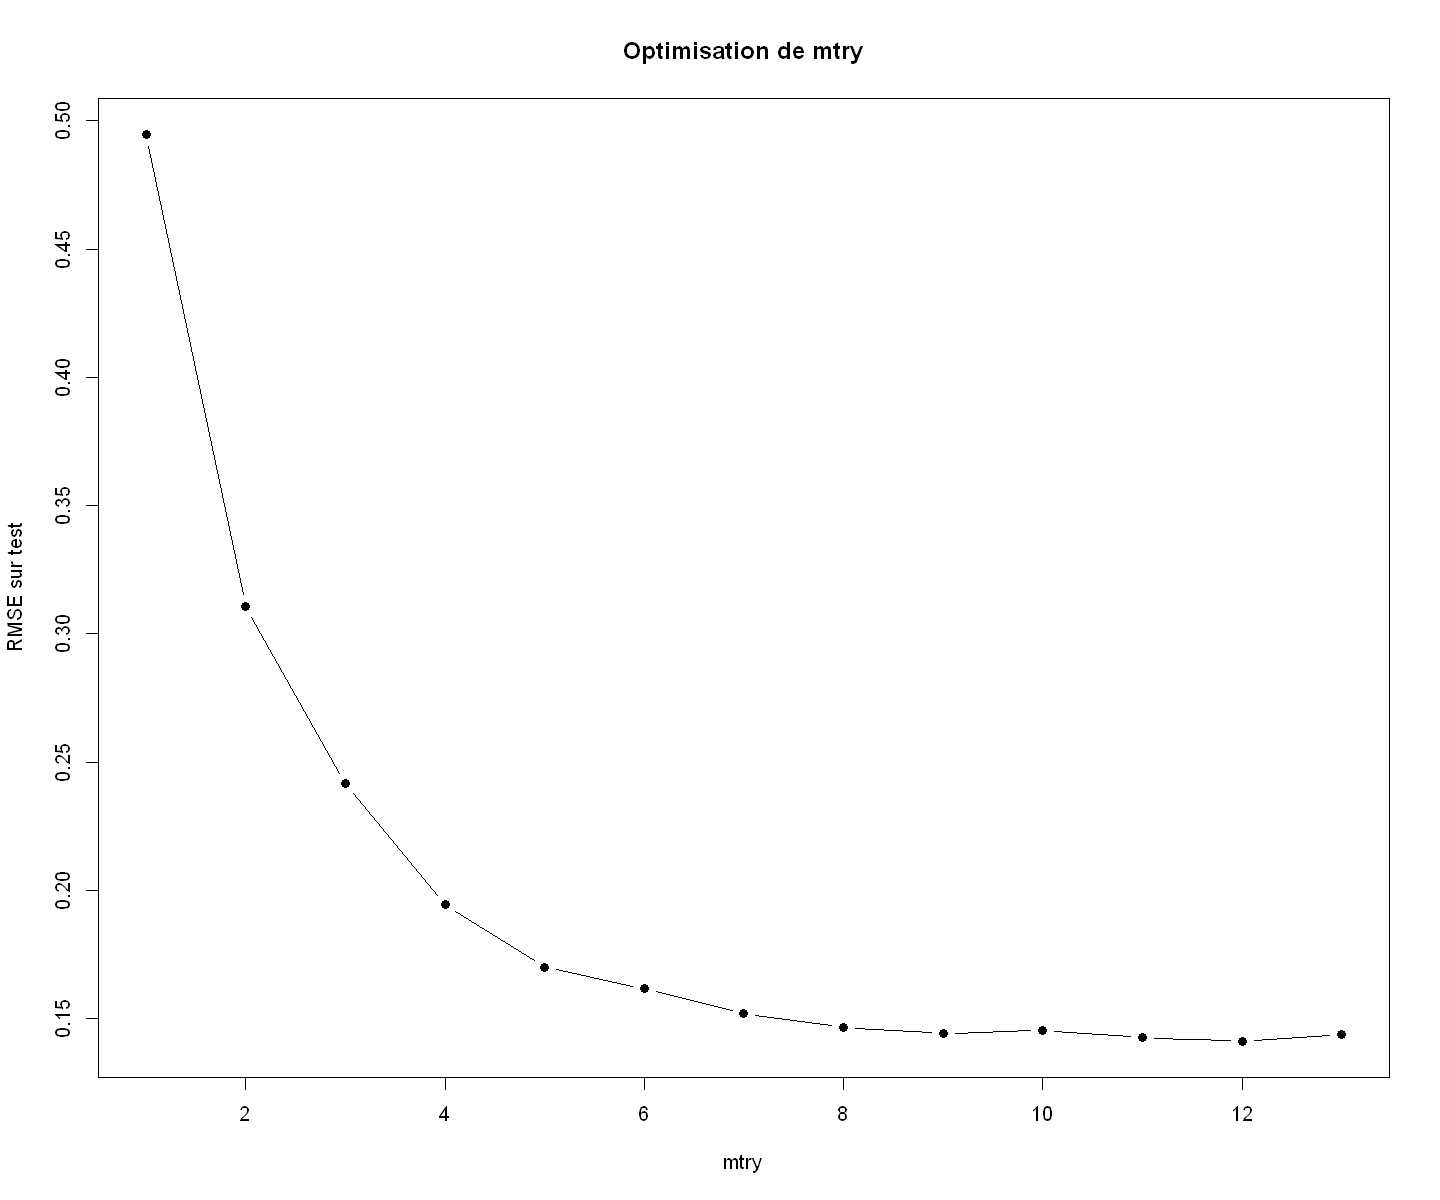

In [205]:
# Optimisation de mtry

p <- ncol(datappr) - 1
mtry.values <- 1:p
rmse.values <- numeric(length(mtry.values))

x_test <- datestr[,-9]

for (i in seq_along(mtry.values)) {
  rf.temp <- randomForest(
    sCalories_Burned ~ ., data = datappr,
    mtry = mtry.values[i], ntree = 500
  )
  
  preds <- predict(rf.temp, newdata = x_test)
  rmse.values[i] <- sqrt(mean((y_test - preds)^2))
}

plot(mtry.values, rmse.values, type = "b", pch = 19,
     xlab = "mtry", ylab = "RMSE sur test", main = "Optimisation de mtry")

best.mtry <- mtry.values[which.min(rmse.values)]
cat("Meilleur mtry :", best.mtry, "\n")

In [206]:
rf.reg.opt=randomForest(sCalories_Burned~., data=datappr,xtest=datestr[,-9],ytest=datestr[,"sCalories_Burned"],
   ntree=500,do.trace=50,importance=TRUE,mtry=12)

     |      Out-of-bag   |       Test set    |
Tree |      MSE  %Var(y) |      MSE  %Var(y) |
  50 |  0.02606     2.61 |  0.02231     2.24 |
 100 |  0.02501     2.50 |  0.02114     2.12 |
 150 |  0.02419     2.42 |  0.02082     2.09 |
 200 |  0.02376     2.38 |  0.02065     2.08 |
 250 |  0.02352     2.36 |  0.02055     2.07 |
 300 |  0.02335     2.34 |   0.0203     2.04 |
 350 |  0.02339     2.34 |  0.02025     2.04 |
 400 |  0.02332     2.34 |  0.02041     2.05 |
 450 |  0.02332     2.33 |  0.02034     2.04 |
 500 |  0.02315     2.32 |  0.02038     2.05 |


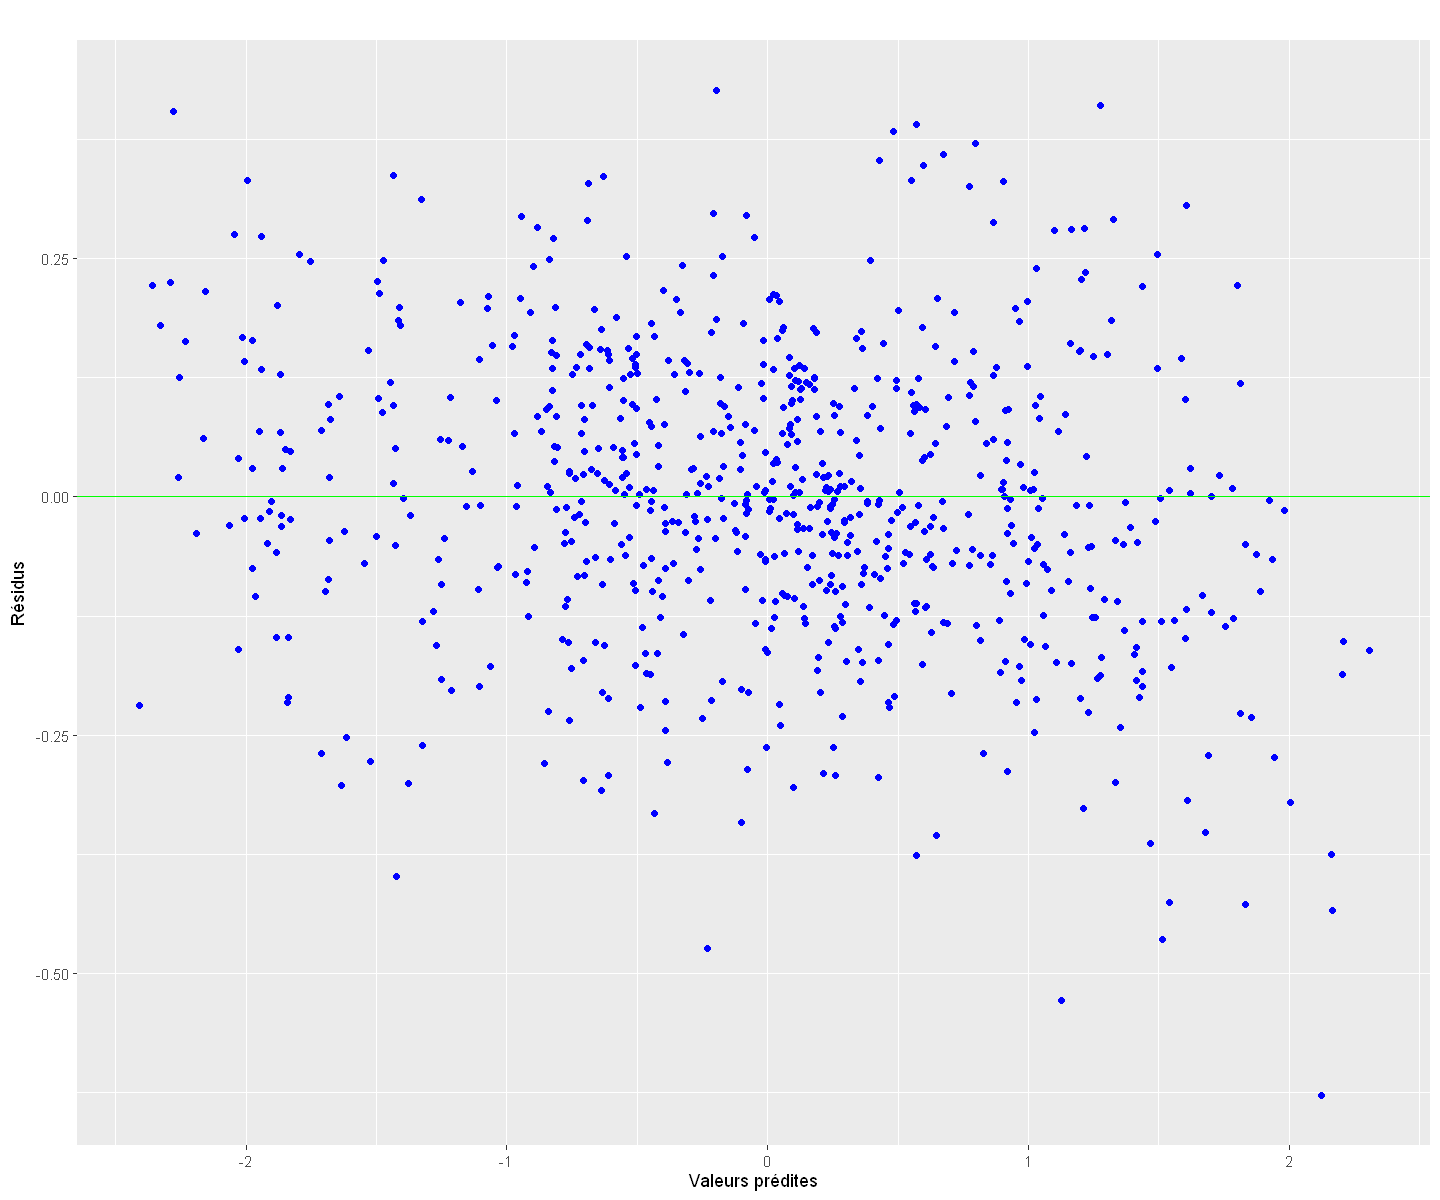

In [209]:
fit.rfr=rf.reg.opt$predicted
res.rfr=fit.rfr-y
gplot.res(fit.rfr,res.rfr,titre="")

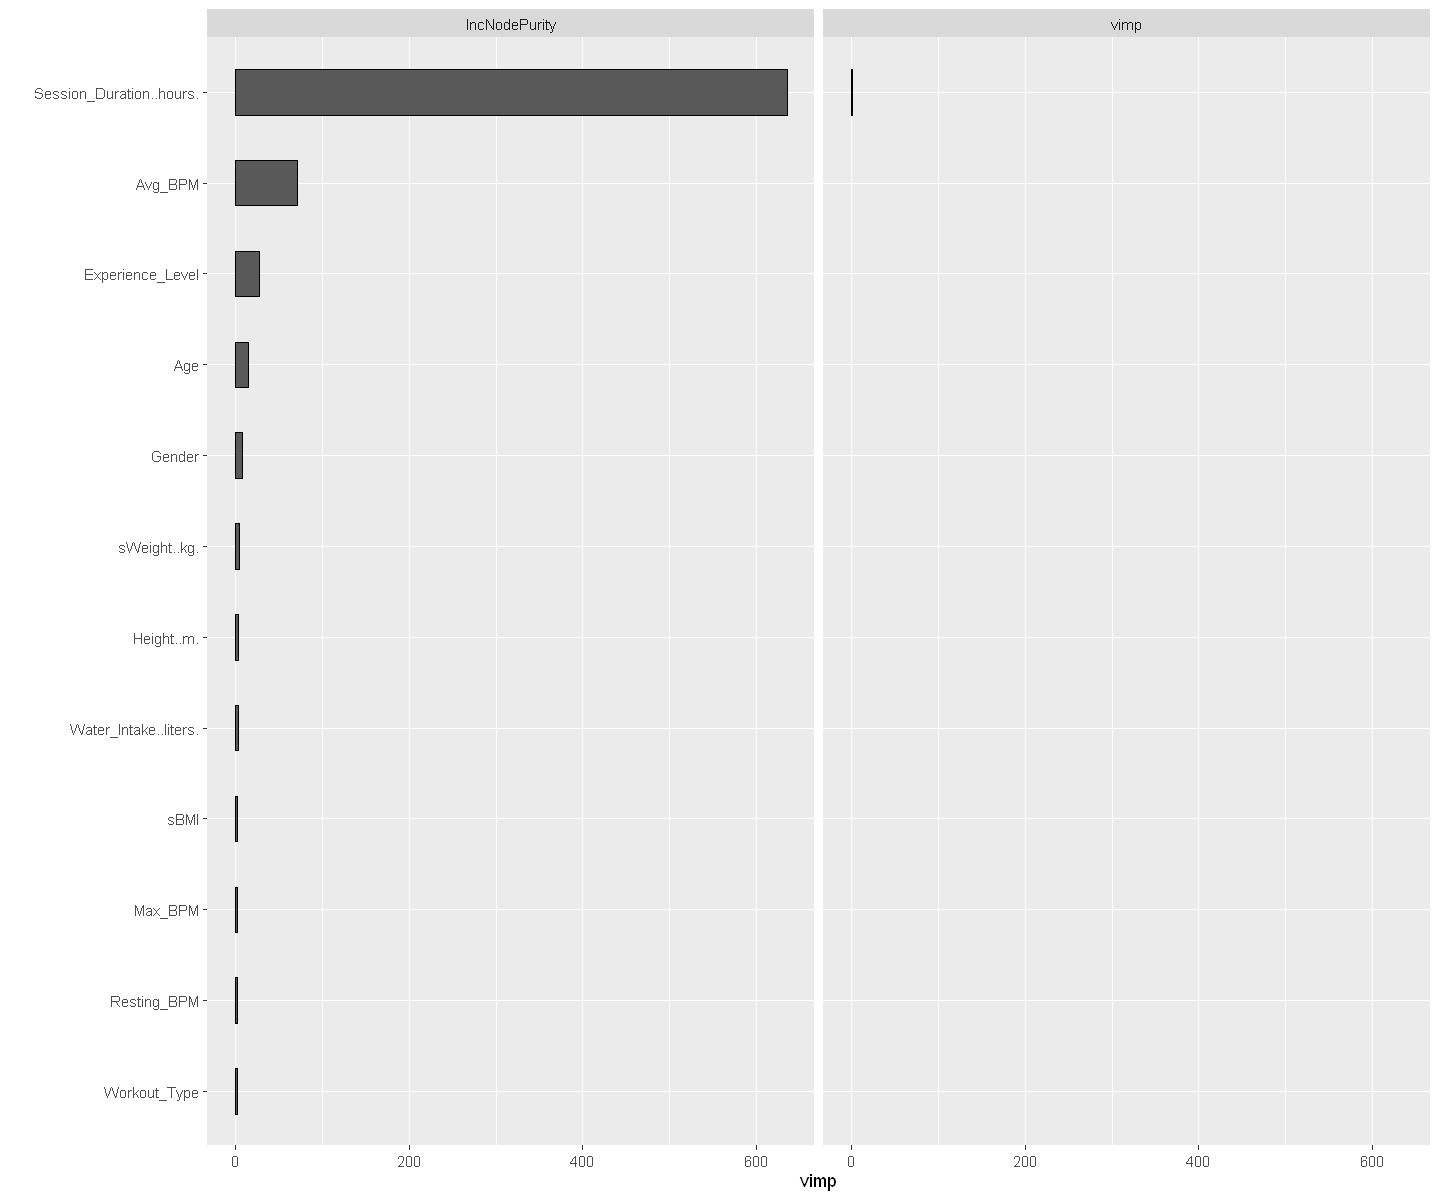

In [211]:
# Importance des variables
plot(gg_vimp(rf.reg.opt))

### RMSE sur l'échantillon de test

In [ ]:
test_forest <- rf.reg.opt$test$predicted

rmse_forest <- sqrt(mean((y_test - test_forest)^2))

cat("RMSE pour random forest :", rmse_forest, "\n")

RMSE pour forêt aléatoire : 0.1427435 


## Boosting

In [232]:
# On optimise le paramètre de shrinkage et le nombre d'arbres:

shrinkages <- c(0.1, 0.05, 0.03, 0.01)
n.trees.max <- 1000
cv.folds <- 10

results <- data.frame(
  shrinkage = numeric(),
  best.iter = integer(),
  rmse = numeric()
)

for (s in shrinkages) {
  
  boost.model <- gbm( sCalories_Burned ~ ., data = datappr, distribution = "gaussian", n.trees = n.trees.max, shrinkage = s, cv.folds = cv.folds, verbose = FALSE)
  
  best.iter <- gbm.perf(boost.model, method = "cv", plot.it = FALSE)
  
  pred <- predict(boost.model, newdata = datestr, n.trees = best.iter)
  
  rmse <- sqrt(mean((datestr$sCalories_Burned - pred)^2))
  
  results <- rbind(results, data.frame(shrinkage = s, best.iter = best.iter, rmse = rmse))
}

print(results)

meilleur <- results[which.min(results$rmse), ]

boost.reg <- gbm( sCalories_Burned ~ ., data = datappr, distribution = "gaussian",  n.trees = meilleur$best.iter, shrinkage = meilleur$shrinkage, cv.folds = cv.folds, verbose = FALSE)


  shrinkage best.iter      rmse
1      0.10       924 0.1023185
2      0.05      1000 0.1007439
3      0.03       995 0.1028935
4      0.01      1000 0.1523399


Les résultats de l'optimisation sont très versatiles. Selon l'execution les paramètres choisis ne sont pas les mêmes

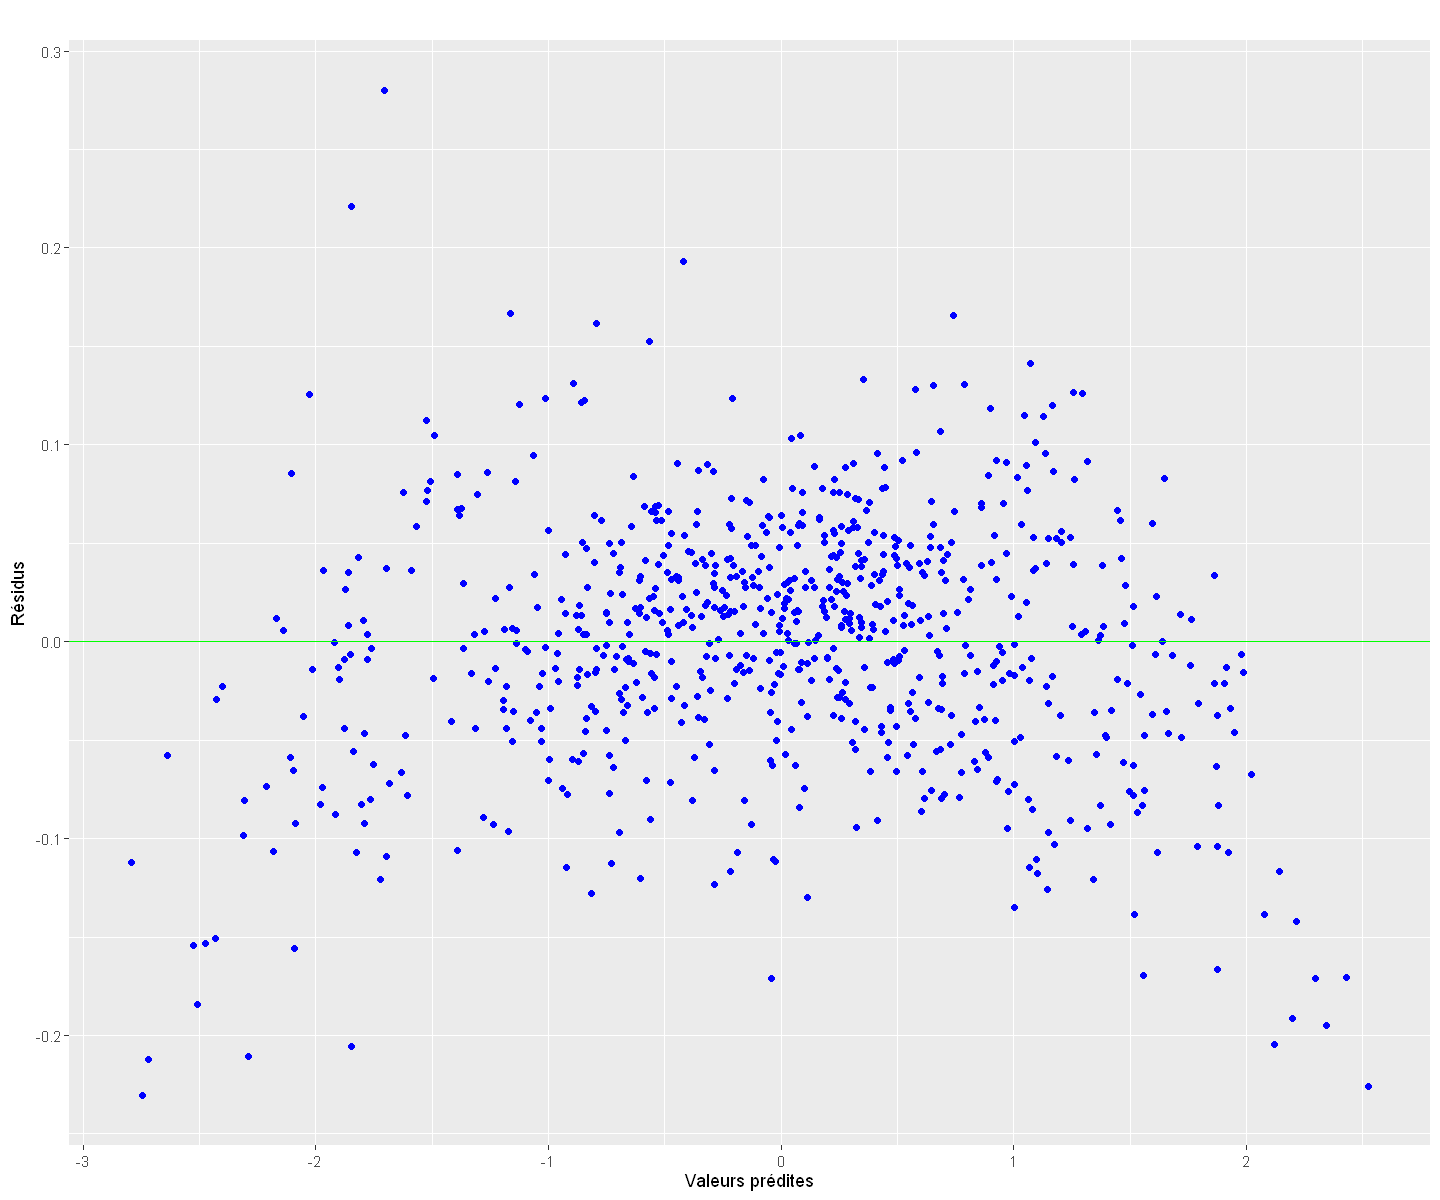

In [233]:
fit.boostr = predict(boost.reg, newdata = datappr, n.trees = meilleur$best.iter, shrinkage = meilleur$shrinkage)
res.boostr = fit.boostr - y

gplot.res(fit.boostr, res.boostr, titre = "")

In [235]:
test_boost <- predict(boost.reg,newdata=datestr,n.trees = meilleur$best.iter, shrinkage = meilleur$shrinkage)
rmse_boost <- sqrt(mean((y_test - test_boost)^2))

cat("RMSE pour boosting :", rmse_boost, "\n")

RMSE pour boosting : 0.1009849 


## 2.1.5 Réseaux de Neurones

Avec nnet le nombre de couches cachées supportées est seulement 1. On optimise les paramètres size, decay qui correspondent respectivement au nombre de neurones dans l'unique couche cachée et à la pénalisation L2.

  size decay
4    5     1


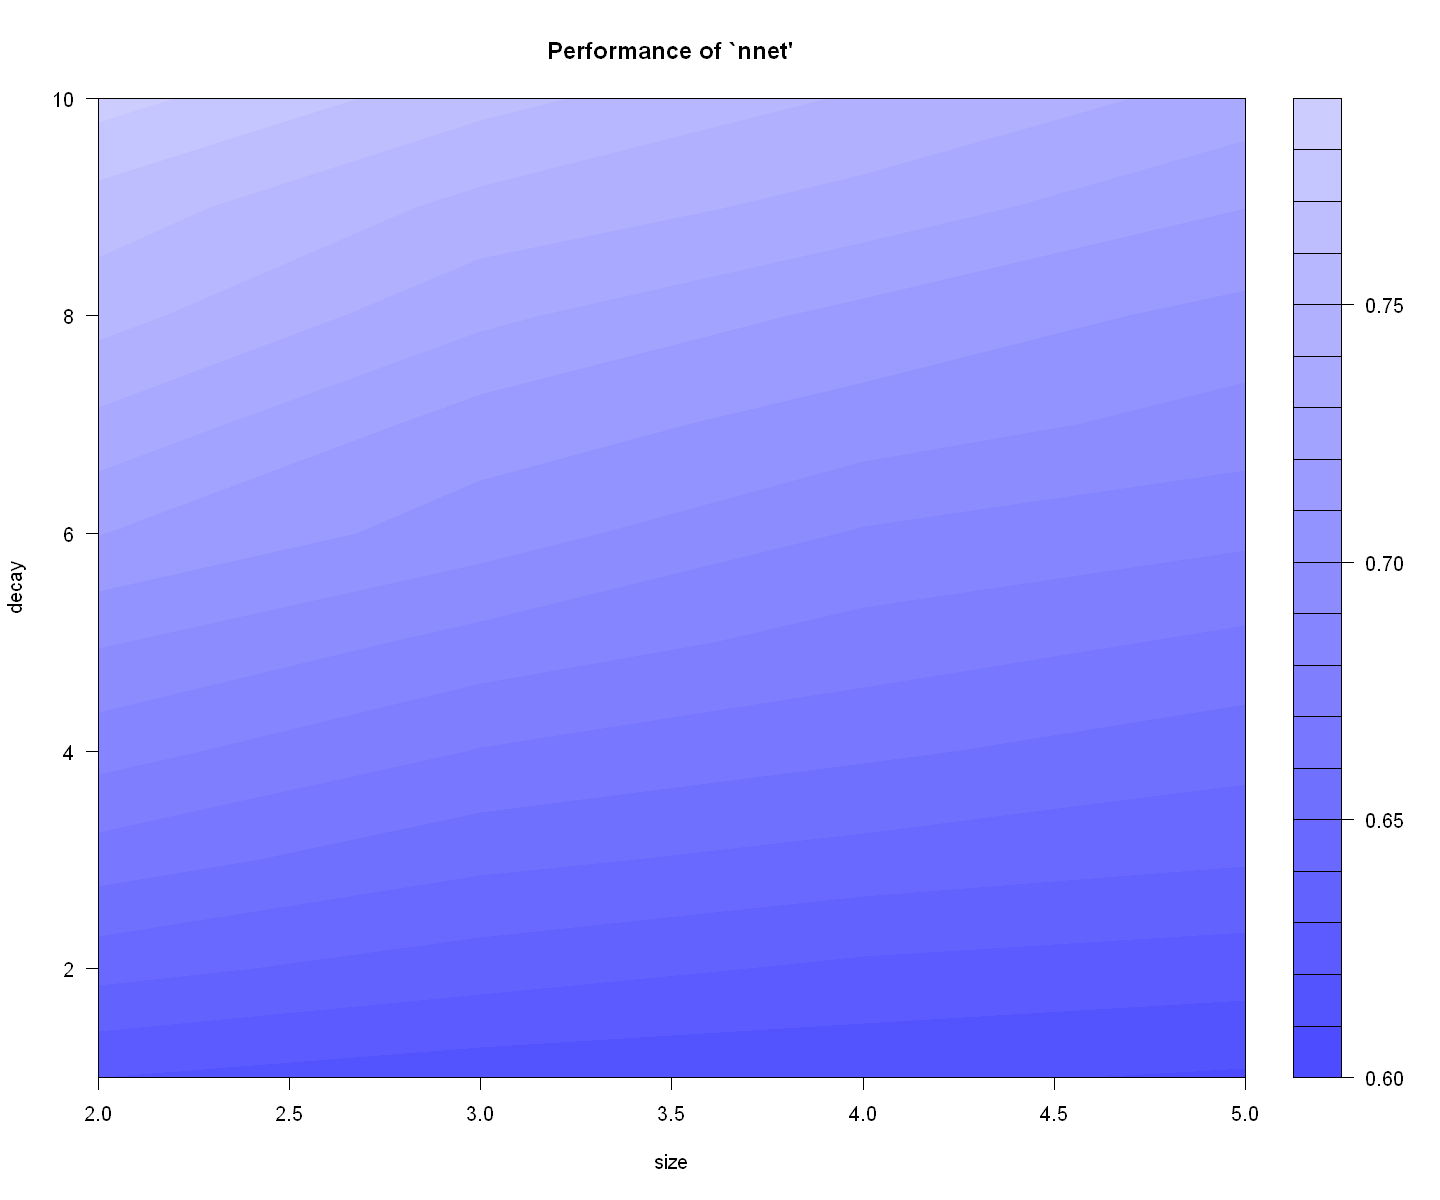

In [237]:
tune.result <- tune.nnet(sCalories_Burned~.,data=datappr,size=2:5,decay=1:10)

plot(tune.result)

best.params <- tune.result$best.parameters
print(best.params)


In [238]:
nnet.reg=nnet(sCalories_Burned~.,data=datappr,size=5,decay=1,linout=TRUE,maxit=500) 
summary(nnet.reg)

# weights:  101
initial  value 925.343522 
iter  10 value 88.979508
iter  20 value 53.414043
iter  30 value 40.550989
iter  40 value 32.877473
iter  50 value 28.063119
iter  60 value 25.996500
iter  70 value 24.194713
iter  80 value 23.679931
iter  90 value 23.318999
iter 100 value 22.852059
iter 110 value 22.600912
iter 120 value 22.348376
iter 130 value 22.214774
iter 140 value 22.086041
iter 150 value 21.986712
iter 160 value 21.936013
iter 170 value 21.918332
iter 180 value 21.911303
iter 190 value 21.907425
iter 200 value 21.905767
iter 210 value 21.904528
iter 220 value 21.899126
iter 230 value 21.883099
iter 240 value 21.873799
iter 250 value 21.873431
iter 260 value 21.873420
final  value 21.873410 
converged


a 18-5-1 network with 101 weights
options were - linear output units  decay=1
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
   0.05    0.16   -0.19    0.08    0.01   -0.08   -0.45    0.07   -0.68    0.03 
i10->h1 i11->h1 i12->h1 i13->h1 i14->h1 i15->h1 i16->h1 i17->h1 i18->h1 
  -0.06    0.07    0.17   -0.08    0.05    0.02   -0.08    0.08    0.02 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
  -0.25   -0.18    0.20    0.04    0.05   -0.02    0.32    0.05    0.52   -0.08 
i10->h2 i11->h2 i12->h2 i13->h2 i14->h2 i15->h2 i16->h2 i17->h2 i18->h2 
  -0.03   -0.04    0.12   -0.10   -0.07   -0.02   -0.11   -0.03    0.06 
  b->h3  i1->h3  i2->h3  i3->h3  i4->h3  i5->h3  i6->h3  i7->h3  i8->h3  i9->h3 
  -0.25   -0.18    0.20    0.04    0.05   -0.02    0.32    0.05    0.52   -0.08 
i10->h3 i11->h3 i12->h3 i13->h3 i14->h3 i15->h3 i16->h3 i17->h3 i18->h3 
  -0.03   -0.04    0.12   -0.10   -0.07   -0.02   -0.11   -0.03    0.06

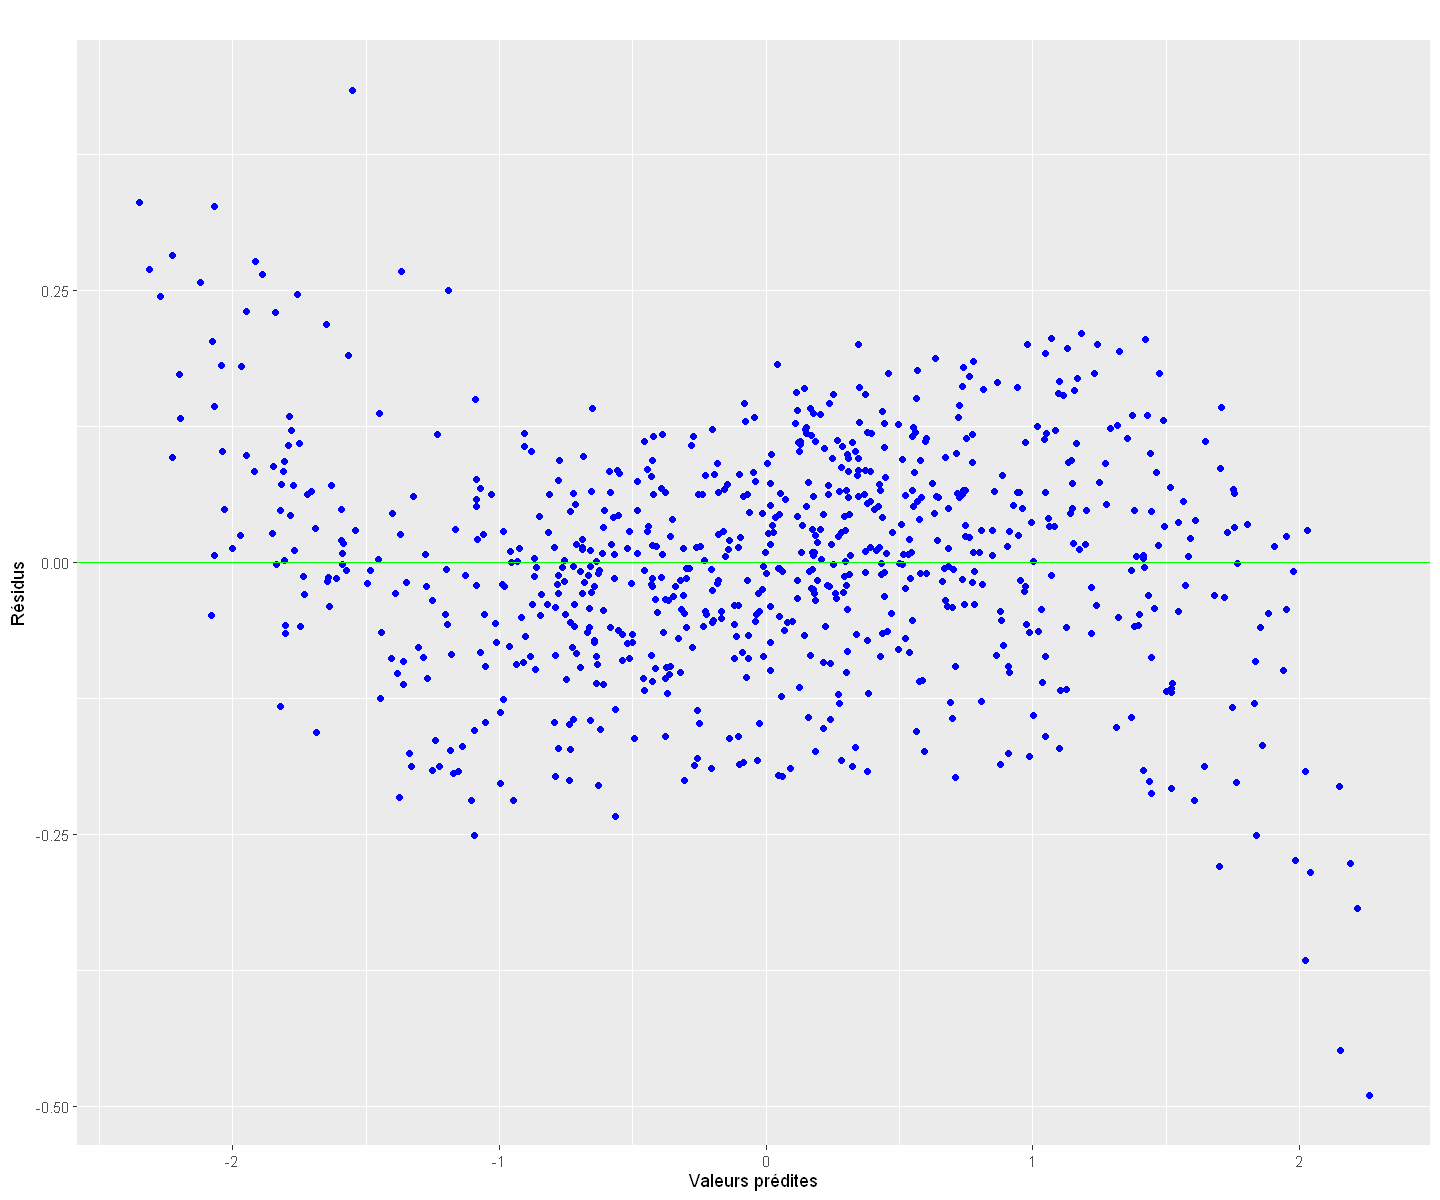

In [239]:
fit.nnetr=predict(nnet.reg,data=datappr)
res.nnetr=fit.nnetr-datappr[,"sCalories_Burned"]
gplot.res(fit.nnetr,res.nnetr,titre="")

### RMSE sur l'échantillon de test

In [240]:
test_nnet <- predict(nnet.reg,newdata=datestr)

rmse_nnet <- sqrt(mean((y_test - test_nnet)^2))

cat("RMSE pour nnet :", rmse_nnet, "\n")

RMSE pour nnet : 0.1164015 
